# Decoding Consumer Choices:
### An In-Depth Analysis of Instacart Market Baskets

### IDC 6940 Capstone Project - Fall 2025 

**Team:** Darien Diaz, Nancy Lopez  
**Mentor:** Agoritsa Polyzou  
**Due Date:** December 8th, 2025  

#### Data:
- Data set from Kaggle: https://www.kaggle.com/datasets/yasserh/instacart-online-grocery-basket-analysis-dataset

#### Install and Import required librarries

In [3]:
# Installation (commented out after first run)
#pip install efficient-apriori
#pip install mlxtend
#pip install prefixspan
#pip install networkx
#!pip install nltk

In [4]:
# libraries
import pandas as pd
import numpy as np
import zipfile
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import itertools
import re
import nltk
import scipy
import textwrap
import networkx as nx
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from mlxtend.frequent_patterns import apriori, association_rules
from efficient_apriori import apriori
from typing import List, Union
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.decomposition import PCA
from wordcloud import WordCloud
from prefixspan import PrefixSpan
from sklearn.metrics.pairwise import euclidean_distances
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# display all characters in columns
pd.set_option('display.max_colwidth', None)

# display all columns
pd.set_option('display.max_columns', None)

# display all rows
pd.set_option('display.max_rows', None)

#### Data Load and Preparation

In [7]:
# -------------------------------------------------
# Load csv files
# -------------------------------------------------
def load_csv_from_zip(zip_file, dtype_dict=None, chunksize=None):
    """Loads a CSV from a ZIP file, selecting the correct file while ignoring macOS metadata."""
    with zipfile.ZipFile(zip_file, 'r') as z:
        # Filter out macOS metadata and ensure we have exactly one CSV
        filenames = [f for f in z.namelist() if f.endswith('.csv') and not f.startswith('__MACOSX') and not f.startswith('._')]
        if len(filenames) != 1:
            raise ValueError(f"Expected exactly 1 CSV file, but found {len(filenames)}: {filenames}")

        filename = filenames[0]
        with z.open(filename) as f:
            if chunksize:
                return pd.concat(pd.read_csv(f, dtype=dtype_dict, chunksize=chunksize))
            else:
                return pd.read_csv(f, dtype=dtype_dict)

In [8]:
# -------------------------------------------------
# Define dtypes for efficiency
# -------------------------------------------------
dtypes_orders = {
    'order_id': 'int32', 'order_number': 'int32', 'user_id': 'int32',
    'order_dow': 'int8', 'order_hour_of_day': 'int8', 'days_since_prior_order': 'float32'
}
dtypes_order_products = {
    'order_id': 'int32', 'product_id': 'int32',
    'add_to_cart_order': 'int16', 'reordered': 'int8'
}

In [9]:
# -------------------------------------------------
# Load datasets from zip files
# -------------------------------------------------
orders = load_csv_from_zip('orders.csv.zip', dtype_dict=dtypes_orders)
order_products_prior = load_csv_from_zip('order_products__prior.csv.zip', dtype_dict=dtypes_order_products)
order_products_train = load_csv_from_zip('order_products__train.csv.zip', dtype_dict=dtypes_order_products)
products = load_csv_from_zip('products.csv.zip', dtype_dict=dtypes_order_products)
departments = load_csv_from_zip('departments.csv.zip')
aisles = load_csv_from_zip('aisles.csv.zip')

In [10]:
# -------------------------------------------------
# Combine prior and train datasets
# -------------------------------------------------
order_products_all = pd.concat([order_products_prior, order_products_train], ignore_index=True)

In [11]:
# -------------------------------------------------
# Merge with orders information
# -------------------------------------------------
order_all_dtl = pd.merge(order_products_all, orders, on='order_id', how='left')

In [12]:
# -------------------------------------------------
# Merge with products information
# -------------------------------------------------
orders_all = pd.merge(order_all_dtl, products, on='product_id', how='left')

## 1. Exploratory Data Analysis - EDA 

### 1.1. Summary Statistics for the Whole Dataset

In [15]:
# -------------------------------------------------
# Stats for the whole dataset
# -------------------------------------------------

# Number of orders per user
orders_per_user = orders_all.groupby('user_id')['order_id'].nunique()

# Number of unique products per user
products_per_user = orders_all.groupby('user_id')['product_id'].nunique()

# Number of products per order (basket size)
products_per_order = orders_all.groupby('order_id')['product_id'].nunique()

# Reorder rate
reorder_rate = orders_all['reordered'].mean()

# Days Since Prior Order
days_since_prior_order = orders_all.groupby('order_id')['days_since_prior_order'].mean()

# Summarize
stats_summary = pd.DataFrame({
    'avg_orders_per_user': [orders_per_user.mean()],
    'avg_products_per_user': [products_per_user.mean()],
    'avg_products_per_order': [products_per_order.mean()],
    'reorder_rate': [reorder_rate],
    'total_orders': [orders_all['order_id'].nunique()],
    'min_orders_per_user': [orders_per_user.min()],
    'max_orders_per_user': [orders_per_user.max()],
    'total_products': [orders_all['product_id'].nunique()],
    'total_users': [orders_all['user_id'].nunique()]
})

print("Summary Statistics for Complete Dataset :")
display(stats_summary)

Summary Statistics for Complete Dataset :


,avg_orders_per_user,avg_products_per_user,avg_products_per_order,reorder_rate,total_orders,min_orders_per_user,max_orders_per_user,total_products,total_users
0,16.226658,67.231527,10.107073,0.590062,3346083,3,100,49685,206209


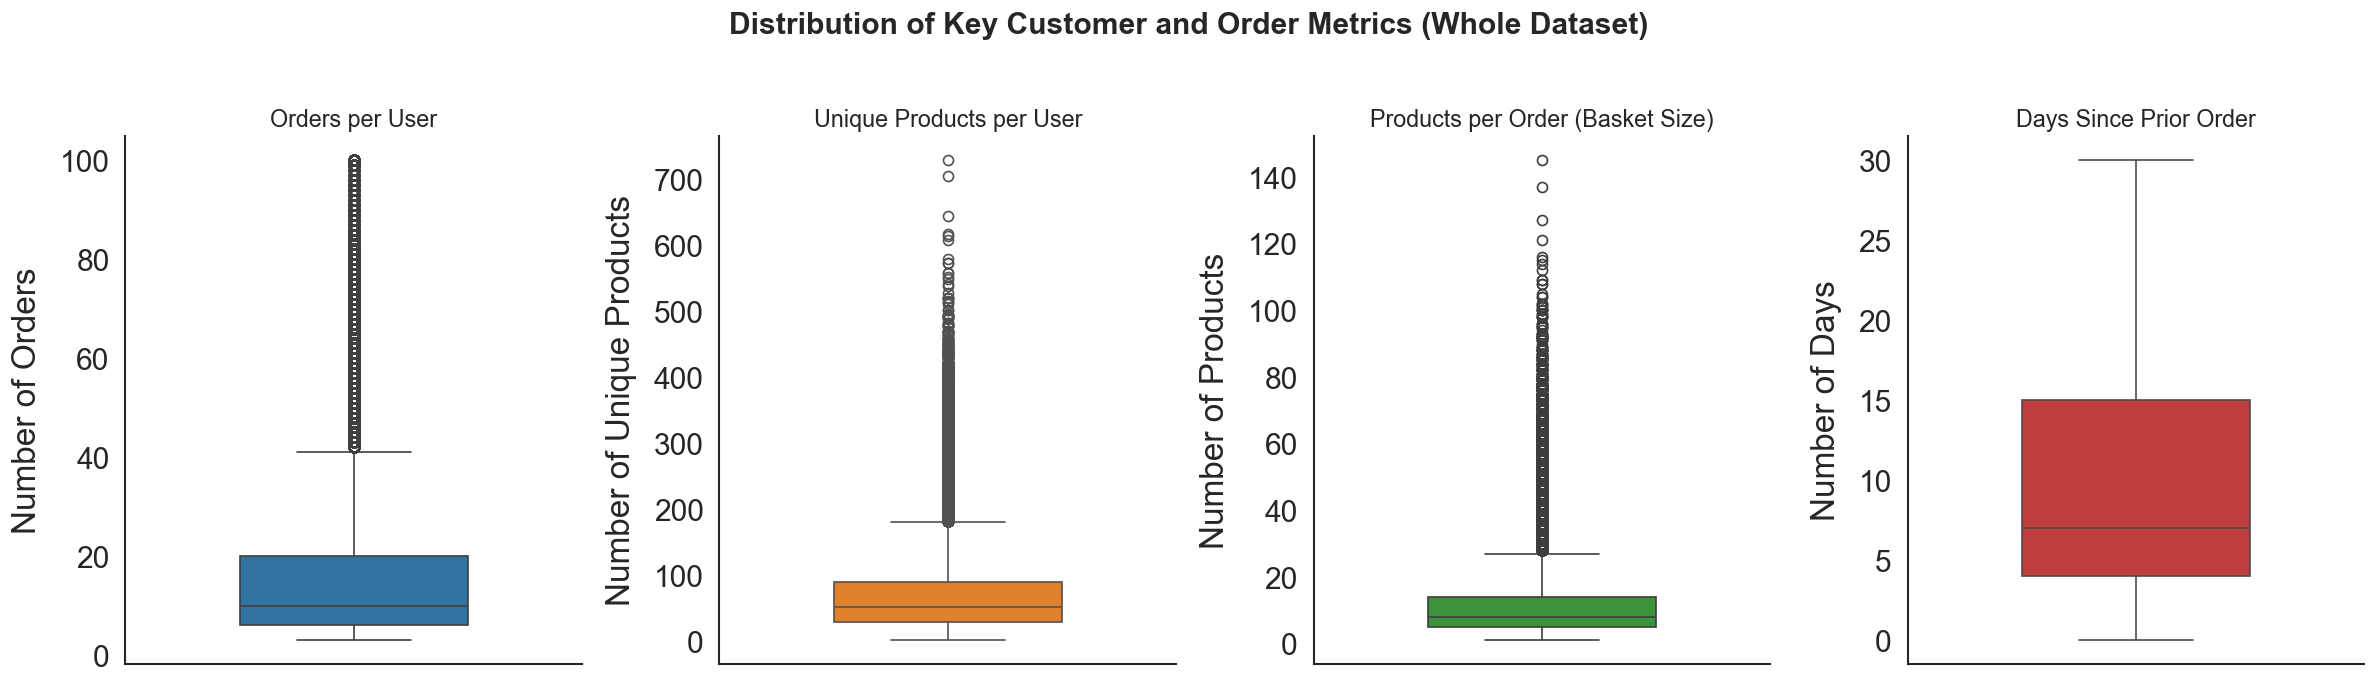

In [16]:
# -------------------------------------------------
# Boxplots for the whole dataset
# -------------------------------------------------

# remove grid lines
sns.set(style="white", palette="tab10", font_scale=1.1)

# Custom color palette
custom_colors = sns.color_palette("tab10", 4)

# Create figure with 4 subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 6), dpi=120)

# Add title
fig.suptitle('Distribution of Key Customer and Order Metrics (Whole Dataset)', fontsize=18, weight='bold')

# Boxplot 1: Orders per User
sns.boxplot(y=orders_per_user, ax=axes[0], color=custom_colors[0], width=0.5, showfliers=True)
axes[0].set_title('Orders per User', fontsize=14)
axes[0].set_ylabel('Number of Orders', fontsize=20, labelpad=10)
axes[0].set_xlabel('')
axes[0].tick_params(axis='y', labelsize=18)
axes[0].spines[['top', 'right']].set_visible(False)
axes[0].grid(False)

# Boxplot 2: Unique Products per User
sns.boxplot(y=products_per_user, ax=axes[1], color=custom_colors[1], width=0.5, showfliers=True)
axes[1].set_title('Unique Products per User', fontsize=14)
axes[1].set_ylabel('Number of Unique Products', fontsize=20, labelpad=10)
axes[1].set_xlabel('')
axes[1].tick_params(axis='y', labelsize=18)
axes[1].spines[['top', 'right']].set_visible(False)
axes[1].grid(False)

# Boxplot 3: Products per Order (Basket Size)
sns.boxplot(y=products_per_order, ax=axes[2], color=custom_colors[2], width=0.5, showfliers=True)
axes[2].set_title('Products per Order (Basket Size)', fontsize=14)
axes[2].set_ylabel('Number of Products', fontsize=20, labelpad=10)
axes[2].set_xlabel('')
axes[2].tick_params(axis='y', labelsize=18)
axes[2].spines[['top', 'right']].set_visible(False)
axes[2].grid(False)

# Boxplot 4: Days Since Prior Order
sns.boxplot(y=days_since_prior_order, ax=axes[3], color=custom_colors[3], width=0.5, showfliers=True)
axes[3].set_title('Days Since Prior Order', fontsize=14)
axes[3].set_ylabel('Number of Days', fontsize=20, labelpad=10)
axes[3].set_xlabel('')
axes[3].tick_params(axis='y', labelsize=18)
axes[3].spines[['top', 'right']].set_visible(False)
axes[3].grid(False)

# Layout adjustments
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [17]:
# -------------------------------------------------
# Stats for the whole dataset
# -------------------------------------------------

# Create a dictionary of datasets
datasets = {
    'Orders per User': orders_per_user,
    'Products per User': products_per_user, 
    'Products per Order': products_per_order, 
    'Days since Prior order': days_since_prior_order
}    
    
# Generate describe() for each and store results
summary_dict = {}
for name, df in datasets.items():
    desc = df.describe()
    summary_dict[name] = desc

# Concatenate along columns with hierarchical index
summary_df = pd.concat(summary_dict, axis=1)
formatted_summary = summary_df.applymap(lambda x: f"{x:,.2f}")

# View metrics as rows and datasets as columns
formatted_summary

,Orders per User,Products per User,Products per Order,Days since Prior order
count,"206,209.00","206,209.00","3,346,083.00","3,139,874.00"
mean,16.23,67.23,10.11,10.97
std,16.66,56.88,7.54,9.14
min,3.00,1.00,1.00,0.00
25%,6.00,28.00,5.00,4.00
50%,10.00,51.00,8.00,7.00
75%,20.00,89.00,14.00,15.00
max,100.00,728.00,145.00,30.00


### 1.2. Behavior Patterns - When do customers purchase?

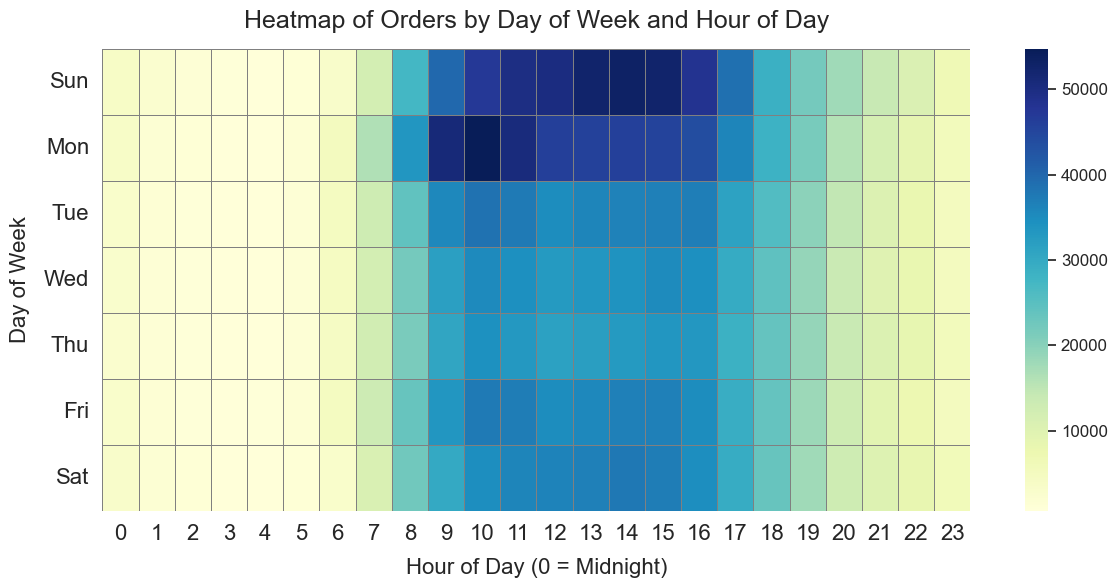

In [19]:
# Group by order_id to get unique orders and extract first occurrence of day and hour
order_times = orders_all.groupby('order_id')[['order_dow', 'order_hour_of_day']].first()

# Create a pivot table: rows = day of week, columns = hour of day, values = order counts
dow_hour_matrix = (
    order_times
    .groupby(['order_dow', 'order_hour_of_day'])
    .size()
    .unstack(fill_value=0)
)

# Reorder day of week for better readability (0=Sunday, 6=Saturday)
dow_labels = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
dow_hour_matrix.index = [dow_labels[d] for d in dow_hour_matrix.index]

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(
    dow_hour_matrix,
    cmap='YlGnBu',
    linewidths=0.5,
    linecolor='gray'
)

# Increase all font sizes
plt.title('Heatmap of Orders by Day of Week and Hour of Day', fontsize=18, pad=15)
plt.xlabel('Hour of Day (0 = Midnight)', fontsize=16, labelpad=10)
plt.ylabel('Day of Week', fontsize=16, labelpad=10)

# tick label sizes
plt.xticks(fontsize=16, rotation=0)
plt.yticks(fontsize=16, rotation=0)

plt.show()


### 1.3. Weekend vs Weekday Patterns

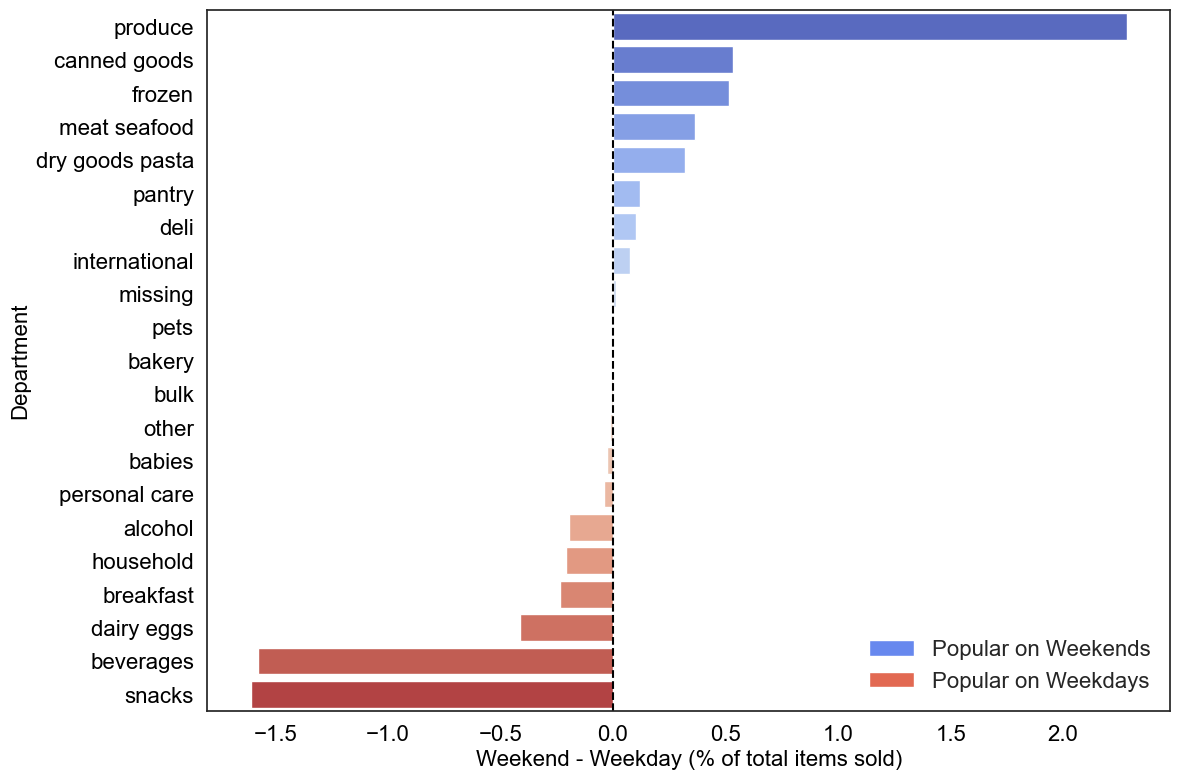

In [21]:
# Are certain product categories more popular on weekends vs. weekdays?
# Prepare data
orders_dept = pd.merge(orders_all, departments, on='department_id', how='left')
orders_dept['is_weekend'] = orders_dept['order_dow'].apply(lambda x: 'Weekend' if x in [0, 6] else 'Weekday')

# Count items sold per department per day type
dept_day_counts = orders_dept.groupby(['department', 'is_weekend'])['order_id'].count().unstack(fill_value=0)

# Normalize by total items sold in each category
dept_day_pct = dept_day_counts.apply(lambda x: x / x.sum(), axis=0)

# Compute % difference
dept_day_pct['Weekend_vs_Weekday_Diff'] = dept_day_pct['Weekend'] - dept_day_pct['Weekday']
dept_day_pct_sorted = dept_day_pct.sort_values('Weekend_vs_Weekday_Diff', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
sns.set_style("white")  # Clean white background, no grid
barplot = sns.barplot(
    y=dept_day_pct_sorted.index,
    x=dept_day_pct_sorted['Weekend_vs_Weekday_Diff'] * 100,
    palette='coolwarm'
)

# Titles and labels
#plt.title('Percentage Point Difference in Items Sold: Weekend vs. Weekday', fontsize=14, color='black')
plt.xlabel('Weekend - Weekday (% of total items sold)', fontsize=16, color='black')
plt.ylabel('Department', fontsize=16, color='black')
plt.axvline(0, color='black', linestyle='--')

# Set all text to black
barplot.tick_params(colors='black')
plt.xticks(color='black', fontsize=16)
plt.yticks(color='black', fontsize=16)

# Add custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=sns.color_palette("coolwarm")[0], label='Popular on Weekends'),
    Patch(facecolor=sns.color_palette("coolwarm")[-1], label='Popular on Weekdays')
]
plt.legend(handles=legend_elements, 
           loc='lower right', frameon=False, fontsize=16)

plt.tight_layout()
plt.show()


### 1.4. New vs Loyal Customer Reorder Rate Patterns

In [23]:
# Do new users (fewer orders) have different buying patterns compared to loyal customers?

# -------------------------------------------------
# Analysis: New vs. Loyal Customers
# -------------------------------------------------

# Calculate max order number (total orders) for each user
user_total_orders = orders.groupby('user_id')['order_number'].max().reset_index(name='total_orders')

# Define Loyalty Segments based on total orders
def categorize_loyalty(orders):
    if orders  <= 5:
        return 'New' # Customer (<= 5 Orders)'
    elif orders <= 15:
        return 'Regular' # Customer (6-15 Orders)'
    else:
        return 'Loyal' # Customer (16+ Orders)'


user_total_orders['loyalty_group'] = user_total_orders['total_orders'].apply(categorize_loyalty)

# Merge loyalty group back into the transaction data (orders_all)
loyalty_df = pd.merge(orders_all, user_total_orders[['user_id', 'loyalty_group']], on='user_id', how='left')

# -------------------------------------------------
# Aggregate Metrics by Loyalty Group
# -------------------------------------------------

# Calculate reorder rate and average basket size by loyalty group
loyalty_stats = loyalty_df.groupby('loyalty_group').agg(
    avg_reorder_rate=('reordered', 'mean'),
    avg_basket_size=('order_id', lambda x: loyalty_df.loc[x.index].groupby('order_id')['product_id'].nunique().mean())
).reset_index()

# Reorder the loyalty groups for visualization
loyalty_order = ['New', 'Regular', 'Loyal']
loyalty_stats['loyalty_group'] = pd.Categorical(loyalty_stats['loyalty_group'], categories=loyalty_order, ordered=True)
loyalty_stats = loyalty_stats.sort_values('loyalty_group')

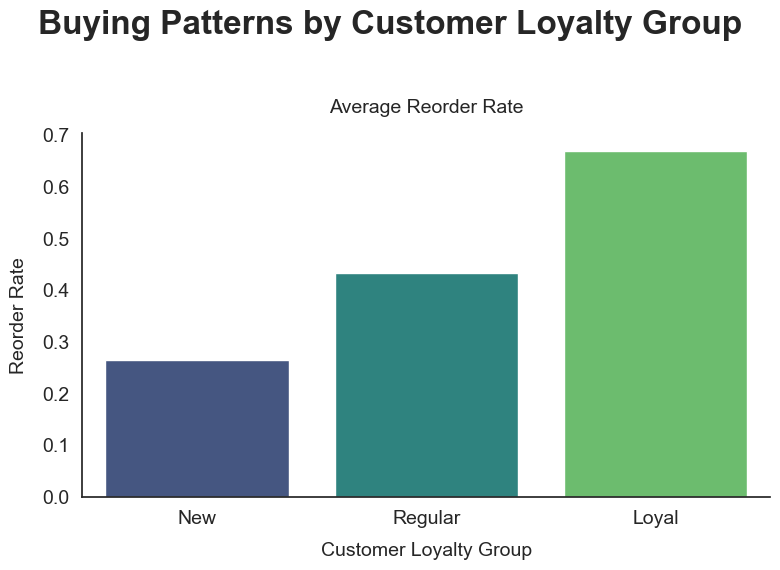

In [24]:
# -------------------------------------------------
# Visualization
# -------------------------------------------------

fig, ax = plt.subplots(figsize=(8, 6))
plt.suptitle('Buying Patterns by Customer Loyalty Group', fontsize=24, fontweight='bold')

# Plot: Average Reorder Rate
sns.barplot(
    x='loyalty_group',
    y='avg_reorder_rate',
    data=loyalty_stats,
    ax=ax,
    palette='viridis'
)

# Titles, labels, and ticks
ax.set_title('Average Reorder Rate', fontsize=14, pad=15)
ax.set_ylabel('Reorder Rate', fontsize=14, labelpad=10)
ax.set_xlabel('Customer Loyalty Group', fontsize=14, labelpad=10)
ax.tick_params(axis='both', labelsize=14)

# Clean visual style
ax.spines[['top', 'right']].set_visible(False)
ax.grid(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [25]:
# Filter for one specific user and show only selected columns (example)
user1_orders = orders_all.loc[orders_all['user_id'] == 206206, 
                              ['user_id', 'order_id', 'days_since_prior_order']]

#print(user1_orders)

### 1.5. Purchasing Frequency

Columns after reset_index: ['avg_days', 'count']


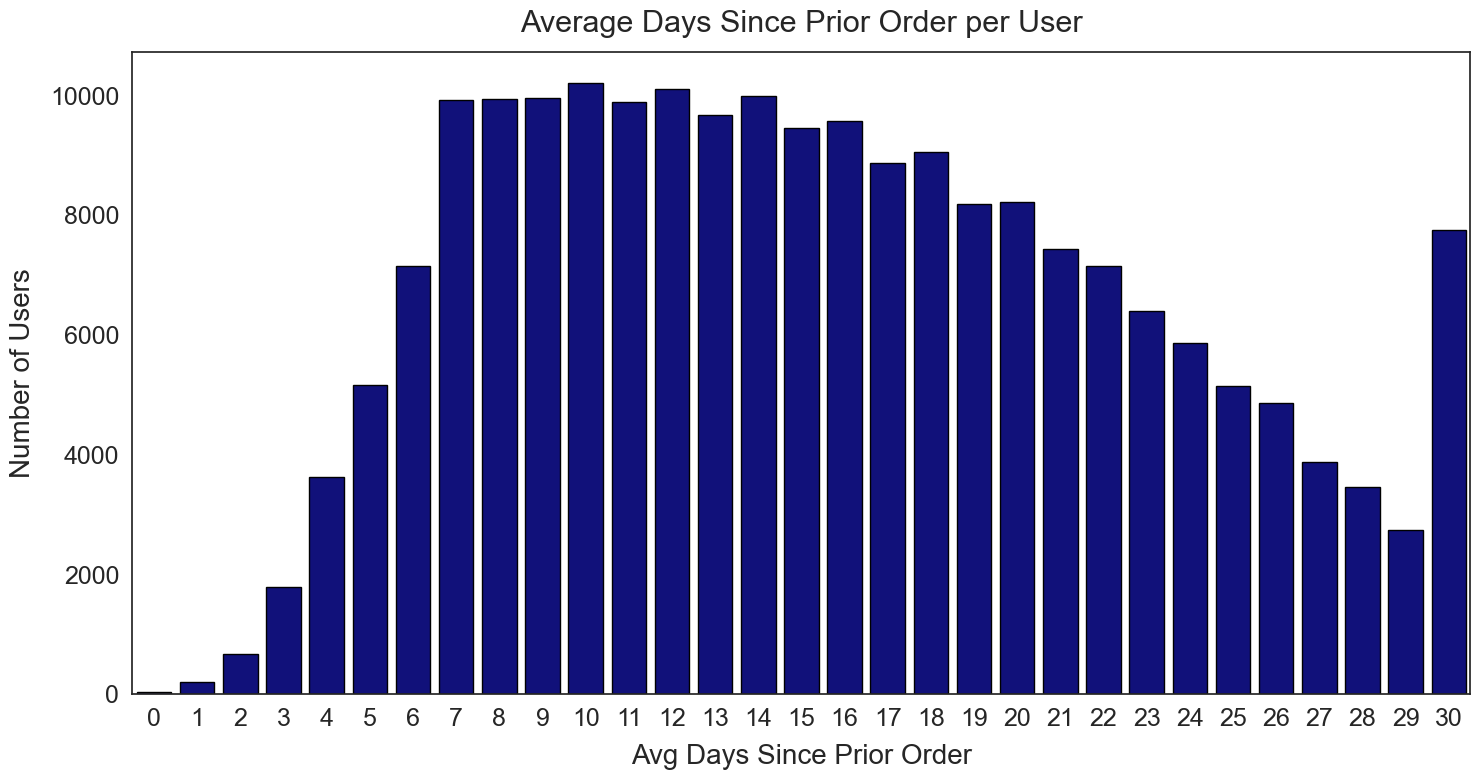

In [27]:
# -------------------------------------------------
# Average Days Since Prior Order per User
# -------------------------------------------------

# 1. Clean column names
orders_all.columns = orders_all.columns.str.strip().str.lower()

# 2. Remove rows with missing values
plot_data = orders_all.dropna(subset=['days_since_prior_order'])

# 3. Compute the average per user
avg_days_per_user = (
    plot_data.groupby('user_id', as_index=False)['days_since_prior_order']
    .mean()
)

# 4. Round and count how many users fall into each average-day value
avg_days_per_user['avg_days'] = avg_days_per_user['days_since_prior_order'].round()

avg_days_counts = avg_days_per_user['avg_days'].value_counts().reset_index()

# print columns
print("Columns after reset_index:", avg_days_counts.columns.tolist())

# 5. Rename columns based on actual names returned
cols = list(avg_days_counts.columns)
avg_days_counts.columns = ['avg_days', 'user_count'] if len(cols) == 2 else cols

# 6. Sort by avg_days
avg_days_counts['avg_days'] = avg_days_counts['avg_days'].astype(int)

# 7. Plot
plt.figure(figsize=(15, 8))
sns.barplot(
    data=avg_days_counts,
    x='avg_days',
    y='user_count',
    color='darkblue',
    edgecolor='black'
)

plt.title('Average Days Since Prior Order per User', fontsize=22, pad=15)
plt.xlabel('Avg Days Since Prior Order', fontsize=20, labelpad=10)
plt.ylabel('Number of Users', fontsize=20, labelpad=10)
plt.xticks(ticks=avg_days_counts['avg_days'].astype(int).unique(),fontsize=18)
plt.yticks(fontsize=18)
plt.grid(False)
plt.tight_layout()
plt.show()


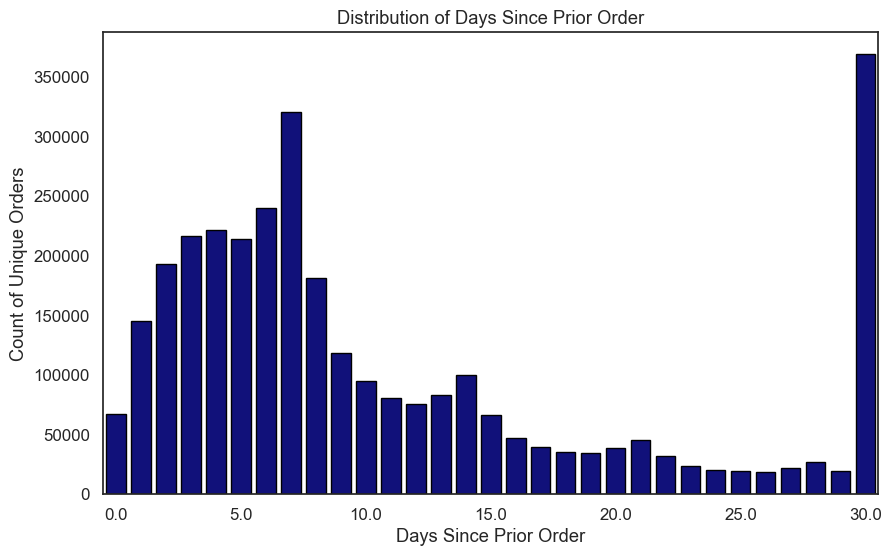

In [28]:
# -------------------------------------------------
# Average Days Since Prior Order (per Order)
# -------------------------------------------------

# 1. Prepare the data: Filter out NaNs, as they have no prior order time.
plot_data = orders.dropna(subset=['days_since_prior_order'])
 
# 2. Drop duplicates to ensure we only count each unique
unique_user_days = plot_data[['user_id', 'days_since_prior_order']]
 
# 3. Create the count for the plot
# Group by the days_since_prior_order and count the remaining unique rows.
unique_user_counts = unique_user_days['days_since_prior_order'].value_counts().reset_index()
unique_user_counts.columns = ['days_since_prior_order', 'unique_user_count']
 
# 4. Sort the data by day for correct plotting order
unique_user_counts = unique_user_counts.sort_values('days_since_prior_order')

# 5. Generate the bar plot
plt.figure(figsize=(10, 6))
 
sns.barplot(
    data=unique_user_counts,
    x='days_since_prior_order',
    y='unique_user_count',
    color='darkblue',
    edgecolor='black'
)
 
# 6. Set labels, title, and grid
plt.title('Distribution of Days Since Prior Order')
plt.xlabel('Days Since Prior Order')
plt.ylabel('Count of Unique Orders')
 
# Customize x-axis ticks for better readability
plt.xticks(range(0, 31, 5))
plt.grid(axis='y')
plt.grid(False)

# 7. Display the plot
plt.show() 

### 1.6. Top Products

In [30]:
# 1. Calculate the total orders and total reorders per product
product_reorder_stats = orders_all.groupby('product_id').agg(
    total_orders=('order_id', 'count'),
    total_reorders=('reordered', 'sum')
)

# 2. Calculate the reorder rate
product_reorder_stats['reorder_rate'] = product_reorder_stats['total_reorders'] / product_reorder_stats['total_orders']

# 3. Filter for products ordered a minimum number of times (e.g., at least 40)
MIN_ORDERS = 40
frequent_products = product_reorder_stats[product_reorder_stats['total_orders'] >= MIN_ORDERS]

# Merge with product names for readability 
if 'products' in globals():
    frequent_products = pd.merge(
        frequent_products, 
        products[['product_id', 'product_name']], 
        on='product_id', 
        how='left'
    )

#### 1.6.1. Top Products Based on Reorder Rate 

In [32]:
# 4. Sort and display the top n based on reorder rate
top_reorder_products = frequent_products.sort_values('reorder_rate', ascending=False).head(1000)

top_reorder_products.head()

,product_id,total_orders,total_reorders,reorder_rate,product_name
3840,6433,69,65,0.942029,Raw Veggie Wrappers
1225,2075,90,84,0.933333,Serenity Ultimate Extrema Overnight Pads
16435,27740,102,94,0.921569,Chocolate Love Bar
8157,13875,45,41,0.911111,Simply Sleep Nighttime Sleep Aid
21656,36543,69,62,0.898551,Bars Peanut Butter


#### 1.6.2. Top Products Based on Total Order

In [34]:
# 4. Sort and display the top n based on total orders
top_order_products = frequent_products.sort_values('total_orders', ascending=False).head(1000)

top_order_products.head()

,product_id,total_orders,total_reorders,reorder_rate,product_name
14759,24852,491291,415166,0.845051,Banana
7736,13176,394930,329275,0.833755,Bag of Organic Bananas
12531,21137,275577,214448,0.778178,Organic Strawberries
13007,21903,251705,194939,0.774474,Organic Baby Spinach
27940,47209,220877,176173,0.797607,Organic Hass Avocado


## 2. Apply NLP to Group Products

In [36]:
# Wordcloud setup
stop_words = set(ENGLISH_STOP_WORDS)
lemmatizer = WordNetLemmatizer()

# stopwords with grocery-specific noise
custom_stopwords = {
    "oz", "pack", "ct", "count", "pk", "fl", "lb", "lbs", "bottle", "bottles", "gallon", "gallons", "bag", "organic", "hass", 
    "large", "small", "red", "green", "white", "yellow", "fresh", "bunch", "chunk", "seedless", "cut", "quick", "easy", "sliced"
}
all_stopwords = stop_words.union(custom_stopwords)

def clean_product_name(text: str) -> str:
    text = text.lower()
    # remove numbers and size patterns
    text = re.sub(r'\d+(\.\d+)?\s*(oz|fl|lb|g|kg|ml|l|pack|pk|ct|count)\b', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    # keep only letters and spaces
    text = re.sub(r'[^a-z\s]', ' ', text)
    # collapse whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # remove stopwords
    tokens = [t for t in text.split() if t not in all_stopwords]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)


In [37]:
# new column
frequent_products["product_name_clean"] = frequent_products["product_name"].astype(str).apply(clean_product_name)

In [38]:
# Add department_id to frequent_products
frequent_products = frequent_products.merge(
    products[['product_id', 'department_id']],
    on='product_id',
    how='left'
)

In [39]:
# print results
frequent_products.head()

,product_id,total_orders,total_reorders,reorder_rate,product_name,product_name_clean,department_id
0,1,1928,1185,0.614627,Chocolate Sandwich Cookies,chocolate sandwich cooky,19
1,2,94,13,0.138298,All-Seasons Salt,season salt,13
2,3,283,209,0.738516,Robust Golden Unsweetened Oolong Tea,robust golden unsweetened oolong tea,7
3,4,351,161,0.458689,Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce,smart one classic favorite mini rigatoni vodka cream sauce,1
4,8,178,90,0.505618,Cut Russet Potatoes Steam N' Mash,russet potato steam n mash,1


In [40]:
# Add department name
frequent_products = frequent_products.merge(
    departments[['department_id', 'department']],
    on='department_id',
    how='left'
)


In [41]:
# reorder columns
frequent_products = frequent_products[
    [
        'product_id', 'product_name', 'product_name_clean',
        'department_id', 'department',
        'total_orders', 'total_reorders', 'reorder_rate'
    ]
]


In [42]:
# print results
frequent_products.head()

,product_id,product_name,product_name_clean,department_id,department,total_orders,total_reorders,reorder_rate
0,1,Chocolate Sandwich Cookies,chocolate sandwich cooky,19,snacks,1928,1185,0.614627
1,2,All-Seasons Salt,season salt,13,pantry,94,13,0.138298
2,3,Robust Golden Unsweetened Oolong Tea,robust golden unsweetened oolong tea,7,beverages,283,209,0.738516
3,4,Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce,smart one classic favorite mini rigatoni vodka cream sauce,1,frozen,351,161,0.458689
4,8,Cut Russet Potatoes Steam N' Mash,russet potato steam n mash,1,frozen,178,90,0.505618


In [43]:
frequent_products.to_csv("frequent_products_with_department_v2.csv", index=False)

In [44]:
# Normalize further

# extend list as more patterns discovered
def normalize_product_group(row):
    name = str(row["product_name_clean"]).lower()
    dept = str(row.get("department", "")).lower() 

    # --- MILK & CREAMERS ---
    if (
        "milk" in name or "oatmilk" in name or
        ("almond" in name and "milk" in name) or
        ("soy" in name and "milk" in name) or
        ("coconut" in name and "milk" in name) or
        "half half" in name or
        "half & half" in name or
        ("creamer" in name and "coffee" in name)
    ):
        return "milk"

    # --- BREAD / BAKERY LOAVES ---
    if (
        "bread" in name or
        "baguette" in name or
        "sourdough" in name or
        "brioche" in name or
        "loaf" in name or
        "sandwich roll" in name or
        ("roll" in name and "dinner" not in name) or
        ("bun" in name)
    ):
        return "bread"

    # --- apple  ---
    if "apple" in name and "produce" in dept:
        return "apple"  
    
    # --- WATER  ---
    if "water" in name and "beverages" in dept:
        return "water"        

    # --- YOGURT ---
    if "yogurt" in name or "yoghurt" in name:
        return "yogurt"

    # --- CHEESE ---
    if "cheese" in name or "mozzarella" in name or "cheddar" in name:
        return "cheese"

    # --- EGGS ---
    if "egg" in name and "eggplant" not in name:
        return "eggs"

    # --- JUICE / SMOOTHIES ---
    if (
        "juice" in name or
        "smoothie" in name or
        "lemonade" in name or
        "cold pressed" in name or
        ("beverage" in name and ("juice" in name or "pressed" in name))
    ):
        return "juice"

    # --- CEREAL / OATMEAL / GRANOLA BARS ---
    if "cereal" in name or "oatmeal" in name or "granola" in name:
        return "cereal / oatmeal"

    # If none of the above matched, keep the cleaned name or tag as 'other'
    return name


In [45]:
frequent_products["product_group_norm"] = frequent_products.apply(
    normalize_product_group,
    axis=1
)

In [46]:
# 4. Sort and display the top n based on total orders
frequent_products_df = frequent_products[["product_id", "product_name", "product_name_clean", "department", 
                                          "product_group_norm", "total_orders","total_reorders"]].sort_values('total_orders', ascending=False)

frequent_products_df.head()

,product_id,product_name,product_name_clean,department,product_group_norm,total_orders,total_reorders
14759,24852,Banana,banana,produce,banana,491291,415166
7736,13176,Bag of Organic Bananas,banana,produce,banana,394930,329275
12531,21137,Organic Strawberries,strawberry,produce,strawberry,275577,214448
13007,21903,Organic Baby Spinach,baby spinach,produce,baby spinach,251705,194939
27940,47209,Organic Hass Avocado,avocado,produce,avocado,220877,176173


In [47]:
frequent_products.to_csv("frequent_products_with_department_v3.csv", index=False)

In [48]:
# Group by cleaned product name
grouped_products = (
    frequent_products_df
        .groupby(["product_group_norm", "department"], as_index=False)
        .agg(
            total_orders_sum=("total_orders", "sum"),
            total_reorders_sum=("total_reorders", "sum")
        )
)

# Recalculate reorder rate
grouped_products["reorder_rate"] = (
    grouped_products["total_reorders_sum"] /
    grouped_products["total_orders_sum"]
)

# sort by reorder_rate or total_orders
grouped_products = grouped_products.sort_values(
    "total_orders_sum", ascending=False
)

grouped_products.head()


,product_group_norm,department,total_orders_sum,total_reorders_sum,reorder_rate
11514,milk,dairy eggs,1997589,1476964,0.739373
20849,yogurt,dairy eggs,1164719,797103,0.684374
2747,cheese,dairy eggs,1100018,644313,0.585730
20469,water,beverages,1010320,732838,0.725352
928,banana,produce,913028,761447,0.833980


#### 2.1. Word Cloud

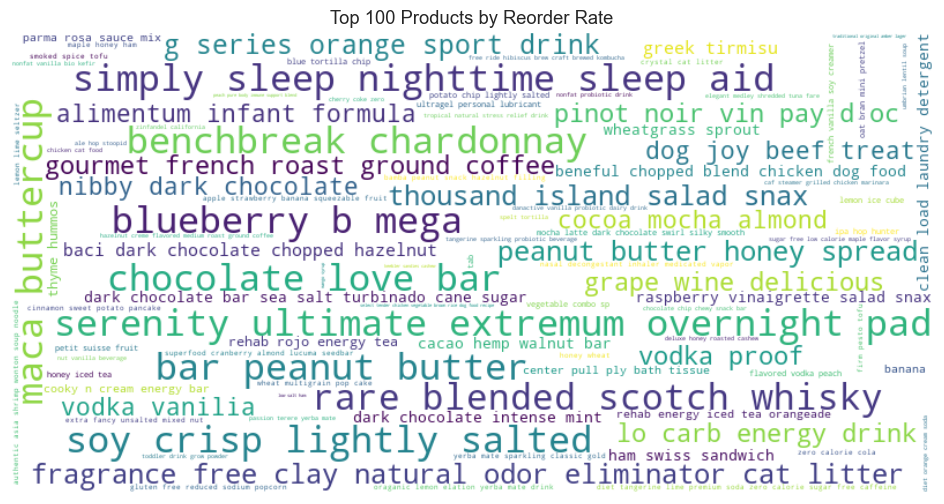

In [50]:
# Top 100 products by reorder rate
top100_by_reorder = (
    grouped_products
    .sort_values('reorder_rate', ascending=False)
    .head(100)
)

# Use reorder_rate as weight
freq_reorder = dict(
    zip(top100_by_reorder['product_group_norm'],
        top100_by_reorder['reorder_rate'])
)

# Create word cloud
wc_reorder = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate_from_frequencies(freq_reorder)

# Plot
plt.figure(figsize=(12, 6))
plt.imshow(wc_reorder, interpolation='bilinear')
plt.axis('off')
plt.title('Top 100 Products by Reorder Rate')
plt.show()


In [51]:
top100_by_reorder.head(10)

,product_group_norm,department,total_orders_sum,total_reorders_sum,reorder_rate
16666,serenity ultimate extremum overnight pad,personal care,90,84,0.933333
3450,chocolate love bar,snacks,102,94,0.921569
16903,simply sleep nighttime sleep aid,other,45,41,0.911111
983,bar peanut butter,pantry,69,62,0.898551
17401,soy crisp lightly salted,snacks,67,60,0.895522
10810,maca buttercup,snacks,104,93,0.894231
1286,benchbreak chardonnay,alcohol,111,99,0.891892
1630,blueberry b mega,beverages,99,88,0.888889
15321,rare blended scotch whisky,alcohol,42,37,0.880952
6837,fragrance free clay natural odor eliminator cat litter,pets,131,114,0.870229


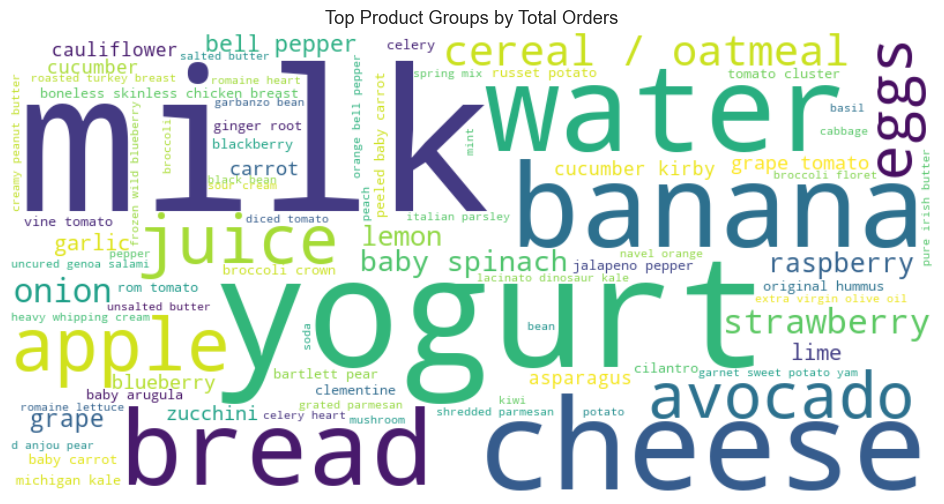

In [52]:
# Top 100 grouped products
top100_by_orders = (
    grouped_products
        .sort_values('total_orders_sum', ascending=False)
        .head(100)
)

# Keep only the highest-order version of each normalized group
top100_unique = (
    top100_by_orders
        .sort_values('total_orders_sum', ascending=False)
        .drop_duplicates(subset='product_group_norm', keep='first')
)

# Build the frequency dictionary for WordCloud
freq_orders = dict(
    zip(top100_unique['product_group_norm'],
        top100_unique['total_orders_sum'])
)

# Create WordCloud
wc_orders = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate_from_frequencies(freq_orders)

plt.figure(figsize=(12, 6))
plt.imshow(wc_orders, interpolation='bilinear')
plt.axis('off')
plt.title('Top Product Groups by Total Orders')
plt.show()


## 3. Data Sampling

In [54]:
# Sample 500,000 orders for basket analysis
sample_order_ids = orders_all['order_id'].drop_duplicates().sample(n=500000, random_state=42)

In [55]:
sample_df = orders_all[orders_all['order_id'].isin(sample_order_ids)]

In [56]:
# Identify Top N Products (by frequency)
top_products = sample_df['product_id'].value_counts().head(20000).index

In [57]:
# Filter Sampled Orders to Only Keep Top N Products
filtered_df = sample_df[sample_df['product_id'].isin(top_products)]

In [58]:
# print results
filtered_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
125,14,20392,1,1,18194,prior,49,3,15,3.0,Hair Bender Whole Bean Coffee,26,7
126,14,27845,2,1,18194,prior,49,3,15,3.0,Organic Whole Milk,84,16
127,14,162,3,1,18194,prior,49,3,15,3.0,Organic Mini Homestyle Waffles,52,1
128,14,2452,4,1,18194,prior,49,3,15,3.0,Naturals Chicken Nuggets,129,1
129,14,8575,5,1,18194,prior,49,3,15,3.0,Unprocessed American Singles Colby-Style Cheese,21,16


In [59]:
# -------------------------------------------------
# Stats for the filtered dataset
# -------------------------------------------------

# Number of orders per user
orders_per_user_s1 = filtered_df.groupby('user_id')['order_id'].nunique()

# Number of unique products per user
products_per_user_s1 = filtered_df.groupby('user_id')['product_id'].nunique()

# Number of products per order (basket size)
products_per_order_s1 = filtered_df.groupby('order_id')['product_id'].nunique()

# Reorder rate
reorder_rate_s1 = filtered_df['reordered'].mean()

# Days Since Prior Order
days_since_prior_order_s1 = filtered_df.groupby('order_id')['days_since_prior_order'].mean()

# Summarize
stats_summary_s1 = pd.DataFrame({
    'avg_orders_per_user': [orders_per_user_s1.mean()],
    'avg_products_per_user': [products_per_user_s1.mean()],
    'avg_products_per_order': [products_per_order_s1.mean()],
    'reorder_rate': [reorder_rate_s1],
    'total_orders': [filtered_df['order_id'].nunique()],
    'min_orders_per_user': [orders_per_user_s1.min()],
    'max_orders_per_user': [orders_per_user_s1.max()],
    'total_products': [filtered_df['product_id'].nunique()],
    'total_users': [filtered_df['user_id'].nunique()]
})

print("Summary Statistics for Filtered Dataset :")
display(stats_summary)

Summary Statistics for Filtered Dataset :


,avg_orders_per_user,avg_products_per_user,avg_products_per_order,reorder_rate,total_orders,min_orders_per_user,max_orders_per_user,total_products,total_users
0,16.226658,67.231527,10.107073,0.590062,3346083,3,100,49685,206209


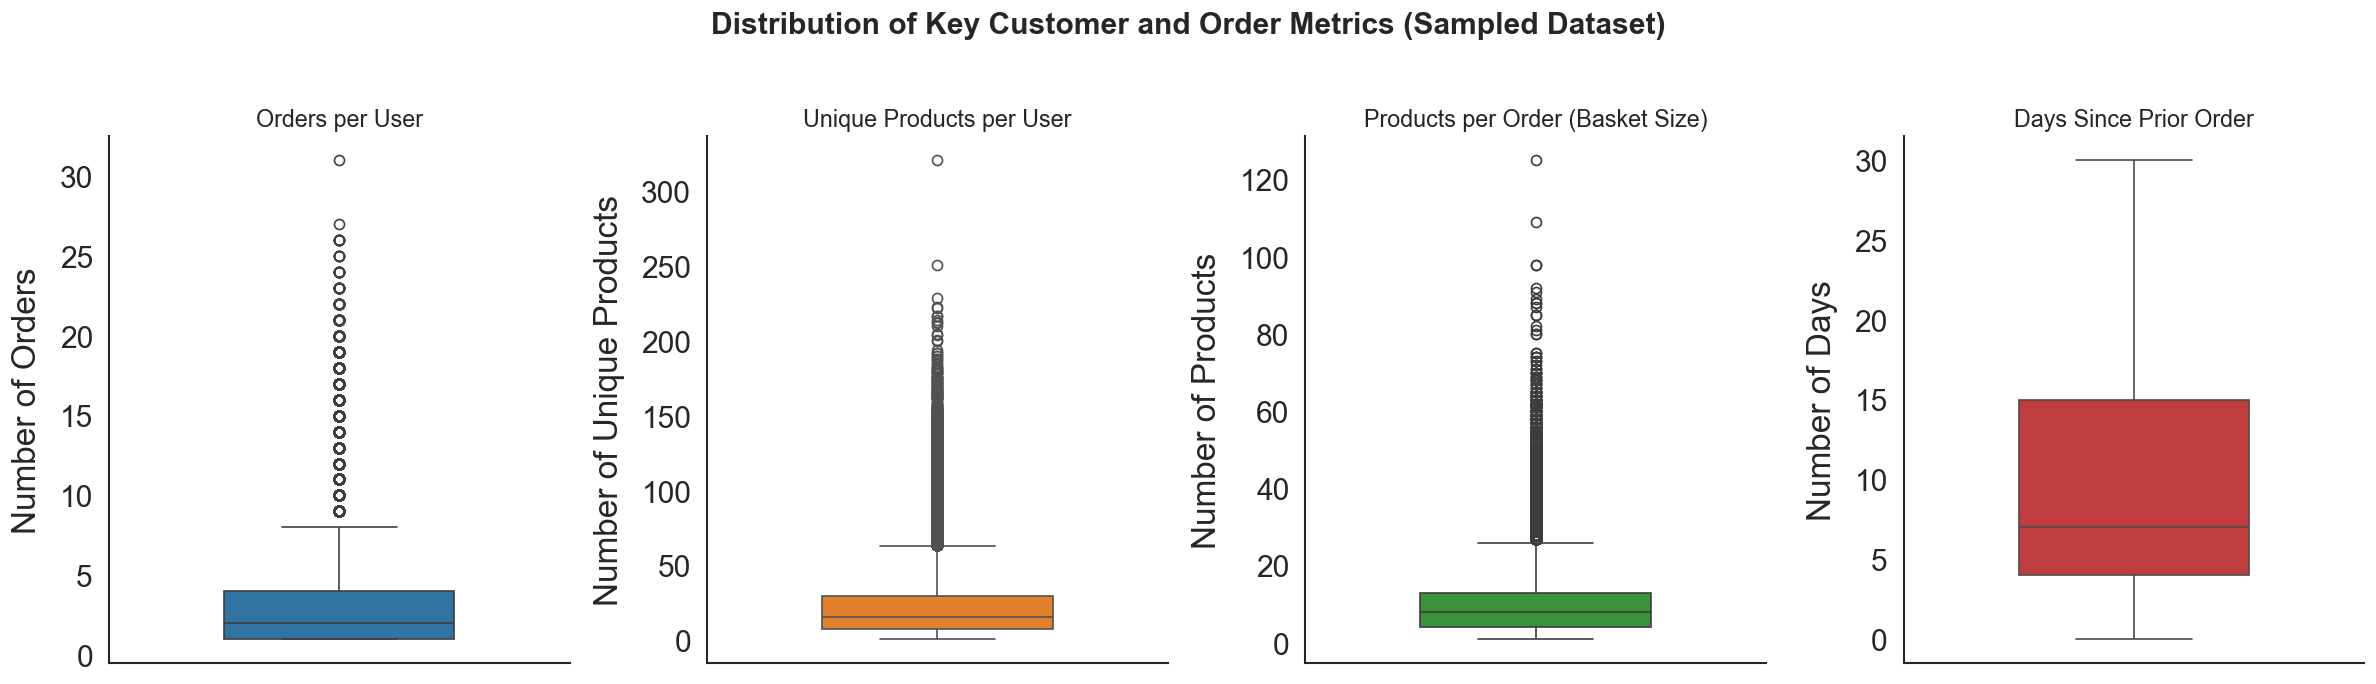

In [60]:
# -------------------------------------------------
# Boxplots for the Filtered dataset
# -------------------------------------------------

# Set a minimalist style without grid lines
sns.set(style="white", palette="tab10", font_scale=1.1)

# Custom color palette
custom_colors = sns.color_palette("tab10", 4)

# Create figure with 4 subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 6), dpi=120)

# Add title
fig.suptitle('Distribution of Key Customer and Order Metrics (Sampled Dataset)', fontsize=18, weight='bold')

# Boxplot 1: Orders per User
sns.boxplot(y=orders_per_user_s1, ax=axes[0], color=custom_colors[0], width=0.5, showfliers=True)
axes[0].set_title('Orders per User', fontsize=14)
axes[0].set_ylabel('Number of Orders', fontsize=20, labelpad=10)
axes[0].set_xlabel('')
axes[0].tick_params(axis='y', labelsize=18)
axes[0].spines[['top', 'right']].set_visible(False)
axes[0].grid(False)

# Boxplot 2: Unique Products per User
sns.boxplot(y=products_per_user_s1, ax=axes[1], color=custom_colors[1], width=0.5, showfliers=True)
axes[1].set_title('Unique Products per User', fontsize=14)
axes[1].set_ylabel('Number of Unique Products', fontsize=20, labelpad=10)
axes[1].set_xlabel('')
axes[1].tick_params(axis='y', labelsize=18)
axes[1].spines[['top', 'right']].set_visible(False)
axes[1].grid(False)

# Boxplot 3: Products per Order (Basket Size)
sns.boxplot(y=products_per_order_s1, ax=axes[2], color=custom_colors[2], width=0.5, showfliers=True)
axes[2].set_title('Products per Order (Basket Size)', fontsize=14)
axes[2].set_ylabel('Number of Products', fontsize=20, labelpad=10)
axes[2].set_xlabel('')
axes[2].tick_params(axis='y', labelsize=18)
axes[2].spines[['top', 'right']].set_visible(False)
axes[2].grid(False)

# Boxplot 4: Days Since Prior Order
sns.boxplot(y=days_since_prior_order_s1, ax=axes[3], color=custom_colors[3], width=0.5, showfliers=True)
axes[3].set_title('Days Since Prior Order', fontsize=14)
axes[3].set_ylabel('Number of Days', fontsize=20, labelpad=10)
axes[3].set_xlabel('')
axes[3].tick_params(axis='y', labelsize=18)
axes[3].spines[['top', 'right']].set_visible(False)
axes[3].grid(False)

# Layout adjustments
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [61]:
# -------------------------------------------------
# Stats for the sampled dataset
# -------------------------------------------------

# Create a Dictionary of Datasets
datasets_s1 = {
    'Orders per User': orders_per_user_s1,
    'Products per User': products_per_user_s1, 
    'Products per Order': products_per_order_s1, 
    'Days since Prior order': days_since_prior_order_s1
}    
    
# Generate describe() for each and store results
summary_dict_s1 = {}
for name, df in datasets_s1.items():
    desc = df.describe()
    summary_dict_s1[name] = desc

# Concatenate along columns with hierarchical index
summary_df_s1 = pd.concat(summary_dict_s1, axis=1)
formatted_summary_s1 = summary_df_s1.applymap(lambda x: f"{x:,.2f}")

# View metrics as rows and datasets as columns
formatted_summary_s1

,Orders per User,Products per User,Products per Order,Days since Prior order
count,"158,308.00","158,308.00","498,942.00","468,102.00"
mean,3.15,22.70,9.86,10.98
std,2.90,21.23,7.37,9.12
min,1.00,1.00,1.00,0.00
25%,1.00,8.00,4.00,4.00
50%,2.00,16.00,8.00,7.00
75%,4.00,30.00,13.00,15.00
max,31.00,321.00,125.00,30.00


## 4. Customer Segmentation

### 4.1. Data Preparation

In [64]:
# 1. Calculate Reorder Rate per User and Department
user_dept_reorder_rate = (
    filtered_df.groupby(['user_id', 'department_id'])['reordered']
    .mean()
    .reset_index(name='reorder_rate')
)


In [65]:
# 2. Pivot to get User-Department Matrix (Features for Clustering)
user_dept_matrix = user_dept_reorder_rate.pivot(
    index='user_id',
    columns='department_id',
    values='reorder_rate'
).fillna(0)


In [66]:
# 3. Standardize the data
scaler = StandardScaler()
user_scaled = scaler.fit_transform(user_dept_matrix)


In [67]:
# 4. PCA dimensionality reduction (2D for clustering visualization + elbow)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(user_scaled)


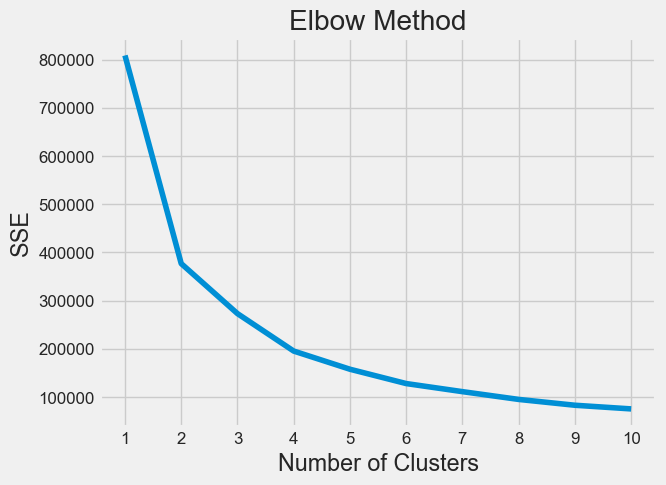

In [68]:
# 5. Determine number of clusters using the Elbow Method
kmeans_kwargs = {
    "init": "random",
    "n_init": 8,
    "max_iter": 300,
    "random_state": 28,
}

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(principal_components)
    sse.append(kmeans.inertia_)

plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title("Elbow Method")
plt.show()


In [69]:
# 6. Perform K-Means Clustering with chosen K
K = 5 ## Based on the Elbow method above
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
user_dept_matrix['cluster'] = kmeans.fit_predict(user_scaled)


In [70]:
user_dept_matrix.describe()

department_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,cluster
count,158308.000000,158308.000000,158308.000000,158308.000000,158308.000000,158308.000000,158308.000000,158308.000000,158308.000000,158308.000000,158308.000000,158308.000000,158308.000000,158308.000000,158308.000000,158308.000000,158308.000000,158308.000000,158308.000000,158308.000000,158308.00000,158308.000000
mean,0.256635,0.007180,0.227986,0.449865,0.018506,0.047236,0.346048,0.014879,0.131663,0.010956,0.049540,0.153050,0.164386,0.140121,0.147767,0.444481,0.089145,0.042835,0.286593,0.203012,0.01415,1.229729
std,0.377435,0.082692,0.384761,0.370991,0.124710,0.199962,0.417994,0.115319,0.304820,0.101445,0.201563,0.333282,0.311777,0.322788,0.317014,0.399168,0.256113,0.187716,0.386635,0.369247,0.11385,1.399868
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
75%,0.500000,0.000000,0.500000,0.777778,0.000000,0.000000,0.772727,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.833333,0.000000,0.000000,0.600000,0.250000,0.00000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,4.000000


In [71]:
# 7. Analyze Cluster Characteristics
user_dept_matrix.columns = user_dept_matrix.columns.astype(str)
department_columns_str = user_dept_matrix.columns.drop('cluster').tolist()

agg_dict = {col: (col, 'mean') for col in department_columns_str}
agg_dict['total_users'] = ('cluster', 'count')

cluster_summary = user_dept_matrix.groupby('cluster').agg(**agg_dict)


In [72]:
# 8. Prepare summary for visualization
display_summary = cluster_summary.copy()
rate_cols = [c for c in display_summary.columns if c != 'total_users']
display_summary[rate_cols] = display_summary[rate_cols] * 100

display_summary = display_summary.reset_index().rename(columns={'cluster': 'Segment ID'})
display_summary_formatted = display_summary.set_index('Segment ID')


In [73]:
if 'departments' in globals():
    dept_map = departments.set_index('department_id')['department'].to_dict()
    new_cols = {}
    for original, col in zip(department_columns_str, department_columns_str):
        dept_name = dept_map.get(int(original), f"ID_{original}")
        new_cols[original] = f"mean_reorder_rate_{dept_name}"
    display_summary_formatted = display_summary_formatted.rename(columns=new_cols, errors='ignore')


In [74]:
display_summary_formatted

,mean_reorder_rate_frozen,mean_reorder_rate_other,mean_reorder_rate_bakery,mean_reorder_rate_produce,mean_reorder_rate_alcohol,mean_reorder_rate_international,mean_reorder_rate_beverages,mean_reorder_rate_pets,mean_reorder_rate_dry goods pasta,mean_reorder_rate_bulk,mean_reorder_rate_personal care,mean_reorder_rate_meat seafood,mean_reorder_rate_pantry,mean_reorder_rate_breakfast,mean_reorder_rate_canned goods,mean_reorder_rate_dairy eggs,mean_reorder_rate_household,mean_reorder_rate_babies,mean_reorder_rate_snacks,mean_reorder_rate_deli,mean_reorder_rate_missing,total_users
Segment ID,,,,,,,,,,,,,,,,,,,,,,
0,29.035765,0.507596,25.024589,61.507367,1.400501,2.097671,42.483161,0.770170,8.016869,0.012505,2.729399,14.345720,15.706849,12.242793,11.510698,64.622536,6.176323,0.459293,34.796413,21.953142,1.326594,56642
1,7.577207,0.213621,5.116811,18.335981,1.931465,0.981784,15.484667,0.660406,2.702858,0.028020,1.512679,4.054645,4.166899,3.138461,3.535061,12.947712,3.368934,0.310820,8.603012,4.405278,0.355717,67214
2,44.508440,1.954790,42.484861,70.548469,0.472485,13.394681,49.627378,1.218269,28.485359,93.867470,10.529703,26.422623,33.408629,29.423839,32.869215,68.963819,15.148135,9.024726,53.507435,40.609226,3.690939,1799
3,50.937629,1.925262,48.154640,67.146785,1.431160,11.395668,54.371732,2.324810,35.879112,0.179312,12.856919,34.057510,32.555281,34.139080,35.628270,70.821291,21.957516,88.272214,52.783715,42.556156,3.479631,6748
4,57.325022,2.086111,55.837152,70.463846,2.830205,17.833904,60.795687,5.004775,44.593887,0.029595,16.301335,40.935840,44.502574,39.780939,44.397880,73.495909,25.460092,0.745555,59.269110,50.725875,3.661071,25905


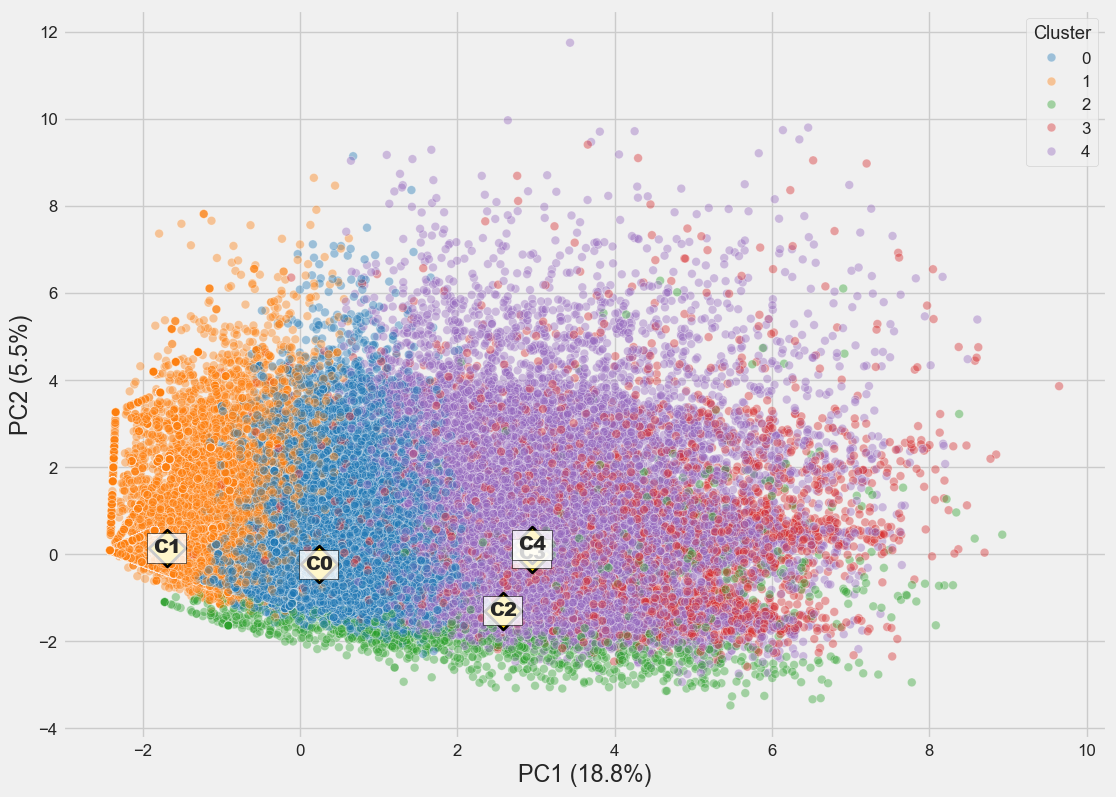

In [75]:
# 9. PCA Visualization
pca_df = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = user_dept_matrix['cluster'].values

centroids_scaled = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids_scaled)

plt.figure(figsize=(12, 9))
sns.scatterplot(
    x='PC1', y='PC2', hue='Cluster', data=pca_df,
    palette=sns.color_palette("tab10", n_colors=K),
    s=40, alpha=0.4
)

plt.scatter(
    centroids_pca[:, 0], centroids_pca[:, 1],
    marker='D', s=350, color='gold',
    edgecolors='black', linewidth=2.0
)

for i, center in enumerate(centroids_pca):
    plt.text(center[0], center[1], f'C{i}',
             fontsize=14, weight='heavy',
             ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='black')
)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.grid(True)
plt.show()



In [76]:
# centroids
centroids = kmeans.cluster_centers_

# Compute centroid-to-centroid distances
dist_matrix = euclidean_distances(centroids)

# Make it a readable DataFrame
dist_df = pd.DataFrame(dist_matrix, 
                       columns=[f"C{c}" for c in range(K)], 
                       index=[f"C{c}" for c in range(K)])

dist_df


,C0,C1,C2,C3,C4
C0,0.000000,2.272820,9.435073,5.164088,3.018089
C1,2.272820,0.000000,9.952380,6.132844,4.716034
C2,9.435073,9.952380,0.000000,10.168624,9.349433
C3,5.164088,6.132844,10.168624,0.000000,4.746178
C4,3.018089,4.716034,9.349433,4.746178,0.000000


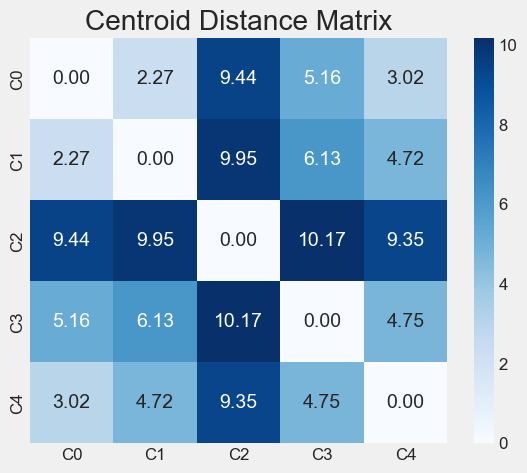

In [77]:
# visualization
plt.figure(figsize=(6,5))
sns.heatmap(dist_df, annot=True, cmap="Blues", fmt=".2f")
plt.title("Centroid Distance Matrix")
plt.show()


### 4.2. Merge prod Norm with Filtered DF

In [79]:
# Select only the columns wanted to bring into filtered_df
freq_cols = frequent_products_df[[
    "product_id",
    "product_name_clean",
    "product_group_norm"
]]

# Merge filtered_df with the cleaned product info
filtered_df = filtered_df.merge(
    freq_cols,
    on="product_id",
    how="left"
)


In [80]:
filtered_df["product_group_norm"] = filtered_df["product_group_norm"].fillna("other")

### 4.3. Efficient Apriori

In [82]:
# add info
filtered_df = filtered_df.merge(
    user_dept_matrix['cluster'],
    left_on='user_id',
    right_index=True,
    how='left'
)

In [83]:
# Filter by Segment 4
segment_4_df = filtered_df[filtered_df['cluster'] == 3].copy()


In [84]:
# Create list of transactions
transactions = (segment_4_df.groupby('order_id')['product_id']
                .apply(list)
                .tolist())

In [85]:
# Start timer
start_time = time.time()
print("Apriori started...")
print(f"Start time: {time.ctime(start_time)}")

# Run Apriori
itemsets, rules = apriori(transactions, min_support=0.005, min_confidence=0.3)

# End timer
end_time = time.time()
 
# Calculate duration
duration = end_time - start_time

# Log results
print("Apriori completed.")
print(f"End time:   {time.ctime(end_time)}")
print(f"Duration:   {duration:.2f} seconds ({duration/60:.2f} minutes)")

Apriori started...
Start time: Sun Dec  7 23:51:07 2025
Apriori completed.
End time:   Sun Dec  7 23:51:09 2025
Duration:   1.96 seconds (0.03 minutes)


In [86]:
print("Frequent itemsets:", len(itemsets))
print("Rules generated:", len(rules))

Frequent itemsets: 3
Rules generated: 103


In [87]:
# itemsets is a dictionary
for length in sorted(itemsets):
    print(f"{length}-itemsets: {len(itemsets[length])}")

# Total number of frequent itemsets
total_itemsets = sum(len(v) for v in itemsets.values())
print(f"\nTotal frequent itemsets: {total_itemsets}")


1-itemsets: 472
2-itemsets: 324
3-itemsets: 23

Total frequent itemsets: 819


In [88]:
# filter itemsets of size 2 or more
records = []
for k, v in itemsets.items():
    if k >= 2:
        for product_ids, support in v.items():
            records.append({'itemset': product_ids, 'support': support, 'length': k})

# Convert to DataFrame
df_frequent = pd.DataFrame(records)

# Function to map product_ids to names
def map_names(product_ids, product_map):
    return [product_map.get(pid, f"Unknown({pid})") for pid in product_ids]

# Create product_id to name mapping
product_map = dict(zip(products['product_id'], products['product_name']))

# Add readable product names column
df_frequent['product_names'] = df_frequent['itemset'].apply(lambda x: map_names(x, product_map))

print(df_frequent[['product_names', 'support', 'length']].head())


                                                                            product_names  \
0                                                  [Organic Milk, Bag of Organic Bananas]   
1                                         [Gluten Free SpongeBob Spinach Littles, Banana]   
2             [Broccoli & Apple Stage 2 Baby Food, Spinach Peas & Pear Stage 2 Baby Food]   
3  [Broccoli & Apple Stage 2 Baby Food, Baby Food Stage 2 Blueberry Pear & Purple Carrot]   
4                                        [100% Raw Coconut Water, Bag of Organic Bananas]   

   support  length  
0      273       2  
1      193       2  
2      232       2  
3      202       2  
4      238       2  


In [89]:
product_map = products.set_index("product_id")["product_name"].to_dict()

In [90]:
# rules
rules_records = []

for rule in rules:
    rules_records.append({
        "antecedent_ids": list(rule.lhs),
        "consequent_ids": list(rule.rhs),
        "support": rule.support,
        "confidence": rule.confidence,
        "lift": rule.lift
    })

rules_products_df = pd.DataFrame(rules_records)


In [91]:
# rules
rules_products_df["antecedent_names"] = rules_products_df["antecedent_ids"].apply(
    lambda ids: [product_map[i] for i in ids]
)

rules_products_df["consequent_names"] = rules_products_df["consequent_ids"].apply(
    lambda ids: [product_map[i] for i in ids]
)


In [92]:
# rules
rules_products_df = rules_products_df[
    [
        "antecedent_ids", "antecedent_names",
        "consequent_ids", "consequent_names",
        "support", "confidence", "lift"
    ]
].sort_values("confidence", ascending=False)


## 5. Association analysis - Aisle

In [94]:
# Create list of transactions
transactions_aisle = (filtered_df.groupby('order_id')['aisle_id']
                .apply(list)
                .tolist())

In [95]:
# Start timer
start_time = time.time()
print("Apriori started...")
print(f"Start time: {time.ctime(start_time)}")

# Run Apriori
itemsets, rules = apriori(transactions_aisle, min_support=0.010, min_confidence=0.3)

# End timer
end_time = time.time()
 
# Calculate duration
duration = end_time - start_time

# Log results
print("Apriori completed.")
print(f"End time:   {time.ctime(end_time)}")
print(f"Duration:   {duration:.2f} seconds ({duration/60:.2f} minutes)")

Apriori started...
Start time: Sun Dec  7 23:51:26 2025
Apriori completed.
End time:   Sun Dec  7 23:52:38 2025
Duration:   72.19 seconds (1.20 minutes)


In [96]:
# only frequent itemsets of size 2 or more

min_size = 2 
records = []
total_transactions = len(transactions_aisle)  # needed for support


In [97]:
# Loop through each size group
for k, item_dict in itemsets.items():
    if k < min_size:
        continue
    for items, count in item_dict.items():
        records.append({
            "itemset_ids": list(items),
            "support_count": count,
            "support": count / total_transactions
        })

itemsets_df = pd.DataFrame(records)


In [98]:
# Convert IDs to names
aisle_map = aisles.set_index("aisle_id")["aisle"].to_dict()

itemsets_df["itemset_names"] = itemsets_df["itemset_ids"].apply(
    lambda ids: [aisle_map[i] for i in ids]
)


In [99]:
itemsets_df['Len'] = itemsets_df['itemset_names'].apply(
    lambda x: len(ast.literal_eval(x)) if isinstance(x, str) else len(x)
)


In [100]:
itemsets_df.head()

,itemset_ids,support_count,support,itemset_names,Len
0,"[1, 24]",6203,0.012432,"[prepared soups salads, fresh fruits]",2
1,"[2, 24]",7693,0.015419,"[specialty cheeses, fresh fruits]",2
2,"[2, 83]",7265,0.014561,"[specialty cheeses, fresh vegetables]",2
3,"[2, 123]",5786,0.011597,"[specialty cheeses, packaged vegetables fruits]",2
4,"[3, 21]",12977,0.026009,"[energy granola bars, packaged cheese]",2


### 5.1. Aisle Network Graph 

In [102]:
# 1. Take top_n itemsets and keep only pairs
top_n = 20
df = (
    itemsets_df
    .sort_values("support", ascending=False)
    .head(top_n)
    .copy()
)

# Ensure Len exists and/or filter to length 2
df['Len'] = df['itemset_names'].apply(
    lambda x: len(ast.literal_eval(x)) if isinstance(x, str) else len(x)
)
df_pairs = df[df['Len'] == 2].copy()

# 2. Build node supports and edges from *pairs only*
edge_weights = {}
node_supports = {}

for _, row in df_pairs.iterrows():
    items = row['itemset_names']
    if isinstance(items, str):
        items = ast.literal_eval(items)
    a, b = sorted([str(i).strip() for i in items])
    supp = row['support']

    # edge weight = EXACT support from the table row
    edge_weights[(a, b)] = supp

    # node support = sum of supports of its pair itemsets
    for item in (a, b):
        node_supports[item] = node_supports.get(item, 0) + supp

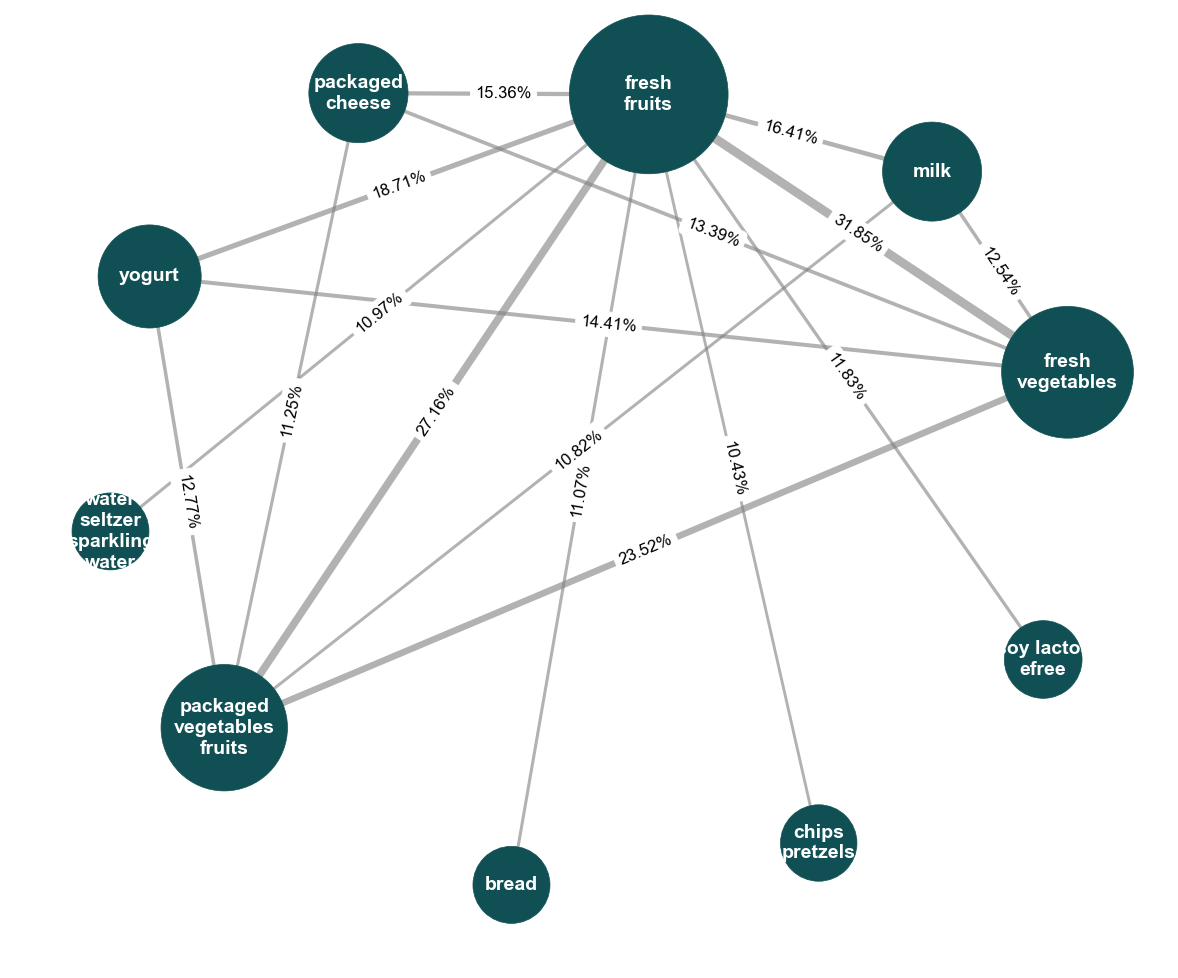

In [103]:
# 3. Build graph
G = nx.Graph()
for item, s in node_supports.items():
    G.add_node(item, support=s)

for (a, b), w in edge_weights.items():
    G.add_edge(a, b, weight=w)

# 4. Dynamic node sizes based on support
node_sizes = [2300 + node_supports[n] * 7000 for n in G.nodes()]

edge_labels = {(u, v): f"{G[u][v]['weight']*100:.2f}%" for u, v in G.edges()}

edge_widths = [G[u][v]['weight'] * 20 for u, v in G.edges()] 

wrapped_labels = {
    n: "\n".join(textwrap.wrap(n, width=10))  # adjust width as needed
    for n in G.nodes()
}

# 5. Layout + plot
fig = plt.figure(figsize=(12, 10), facecolor="white")  # white figure background
ax = plt.gca()
ax.set_facecolor("white")                            # white axes background

pos = nx.spring_layout(G, k=10, scale=10, iterations=300, seed=42)

# nodes not transparent (alpha=1)
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="#105054", alpha=1.0)
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color="gray", alpha=0.6)

# use wrapped labels
nx.draw_networkx_labels(G, pos, labels=wrapped_labels, font_size=14, font_color="white", font_weight="bold")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12, label_pos=0.5)

# no title
plt.axis("off")
plt.tight_layout()
plt.show()


### 5.2. Aisle Rules

In [105]:
# Create ID to name dictionary
aisle_map = aisles.set_index("aisle_id")["aisle"].to_dict()


In [106]:
# rules
rules_records = []

for rule in rules:
    rules_records.append({
        "antecedent_ids": list(rule.lhs),
        "consequent_ids": list(rule.rhs),
        "support": rule.support,
        "confidence": rule.confidence,
        "lift": rule.lift
    })

rules_df = pd.DataFrame(rules_records)


In [107]:
# Convert IDs to aisle names using the aisle_map
rules_df["antecedent_names"] = rules_df["antecedent_ids"].apply(
    lambda ids: [aisle_map[i] for i in ids]
)

rules_df["consequent_names"] = rules_df["consequent_ids"].apply(
    lambda ids: [aisle_map[i] for i in ids]
)


In [108]:
# rules
rules_df = rules_df[
    [
        "antecedent_ids", "antecedent_names",
        "consequent_ids", "consequent_names",
        "support", "confidence", "lift"
    ]
].sort_values("confidence", ascending=False)

rules_df.head()


,antecedent_ids,antecedent_names,consequent_ids,consequent_names,support,confidence,lift
2621,"[16, 24, 81]","[fresh herbs, fresh fruits, canned jarred vegetables]",[83],[fresh vegetables],0.012520,0.935880,2.102015
5299,"[16, 24, 91, 123]","[fresh herbs, fresh fruits, soy lactosefree, packaged vegetables fruits]",[83],[fresh vegetables],0.011362,0.932862,2.095235
2614,"[16, 24, 59]","[fresh herbs, fresh fruits, canned meals beans]",[83],[fresh vegetables],0.010556,0.932212,2.093777
2617,"[16, 24, 69]","[fresh herbs, fresh fruits, soup broth bouillon]",[83],[fresh vegetables],0.011346,0.928489,2.085415
5306,"[16, 24, 120, 123]","[fresh herbs, fresh fruits, yogurt, packaged vegetables fruits]",[83],[fresh vegetables],0.015487,0.924946,2.077456


## 6. Association Analysis Department

In [110]:
# Create list of transactions
transactions_dept = (filtered_df.groupby('order_id')['department_id']
                .apply(list)
                .tolist())

In [111]:
# Start timer
start_time = time.time()
print("Apriori started...")
print(f"Start time: {time.ctime(start_time)}")

# Run Apriori
itemsets, rules = apriori(transactions_dept, min_support=0.010, min_confidence=0.3)

# End timer
end_time = time.time()
 
# Calculate duration
duration = end_time - start_time

# Log results
print("Apriori completed.")
print(f"End time:   {time.ctime(end_time)}")
print(f"Duration:   {duration:.2f} seconds ({duration/60:.2f} minutes)")

Apriori started...
Start time: Sun Dec  7 23:52:59 2025
Apriori completed.
End time:   Sun Dec  7 23:54:54 2025
Duration:   115.53 seconds (1.93 minutes)


In [112]:
# only frequent itemsets of size 2 or more

min_size = 2 
records = []
total_transactions = len(transactions_dept)  # needed for support

In [113]:
# Loop through each size group
for k, item_dict in itemsets.items():
    if k < min_size:
        continue
    for items, count in item_dict.items():
        records.append({
            "itemset_ids": list(items),
            "support_count": count,
            "support": count / total_transactions
        })

dept_itemsets_df = pd.DataFrame(records)

### 6.1. Rules Department

In [115]:
# Create ID to name dictionary
dept_map = departments.set_index("department_id")["department"].to_dict()

In [116]:
# rules
rules_records = []

for rule in rules:
    rules_records.append({
        "antecedent_ids": list(rule.lhs),
        "consequent_ids": list(rule.rhs),
        "support": rule.support,
        "confidence": rule.confidence,
        "lift": rule.lift
    })

rules_df = pd.DataFrame(rules_records)

In [117]:
# Convert IDs to aisle names using your aisle_map
rules_df["antecedent_names"] = rules_df["antecedent_ids"].apply(
    lambda ids: [dept_map[i] for i in ids]
)

rules_df["consequent_names"] = rules_df["consequent_ids"].apply(
    lambda ids: [dept_map[i] for i in ids]
)

In [118]:
# rules
rules_df = rules_df[
    [
        "antecedent_ids", "antecedent_names",
        "consequent_ids", "consequent_names",
        "support", "confidence", "lift"
    ]
].sort_values("confidence", ascending=False)

rules_df.head(10)

,antecedent_ids,antecedent_names,consequent_ids,consequent_names,support,confidence,lift
26994,"[9, 13, 15, 16, 19, 20]","[dry goods pasta, pantry, canned goods, dairy eggs, snacks, deli]",[4],[produce],0.011236,0.964058,1.285049
22355,"[12, 13, 15, 16, 20]","[meat seafood, pantry, canned goods, dairy eggs, deli]",[4],[produce],0.011949,0.962078,1.282410
24157,"[1, 3, 4, 14, 19, 20]","[frozen, bakery, produce, breakfast, snacks, deli]",[16],[dairy eggs],0.011975,0.961848,1.420001
26547,"[3, 4, 13, 14, 19, 20]","[bakery, produce, pantry, breakfast, snacks, deli]",[16],[dairy eggs],0.010739,0.961766,1.419880
22185,"[9, 13, 15, 19, 20]","[dry goods pasta, pantry, canned goods, snacks, deli]",[4],[produce],0.011861,0.961339,1.281423
25937,"[3, 4, 7, 9, 13, 20]","[bakery, produce, beverages, dry goods pasta, pantry, deli]",[16],[dairy eggs],0.010356,0.960587,1.418140
23693,"[1, 3, 4, 9, 14, 19]","[frozen, bakery, produce, dry goods pasta, breakfast, snacks]",[16],[dairy eggs],0.010685,0.960541,1.418071
26303,"[3, 4, 7, 14, 19, 20]","[bakery, produce, beverages, breakfast, snacks, deli]",[16],[dairy eggs],0.011759,0.960229,1.417611
26467,"[3, 9, 15, 16, 19, 20]","[bakery, dry goods pasta, canned goods, dairy eggs, snacks, deli]",[4],[produce],0.010035,0.960115,1.279793
22128,"[4, 9, 13, 14, 20]","[produce, dry goods pasta, pantry, breakfast, deli]",[16],[dairy eggs],0.010029,0.960092,1.417409


In [119]:
rules_df.describe()

,support,confidence,lift
count,27262.000000,27262.000000,27262.000000
mean,0.021559,0.518089,2.040969
std,0.020286,0.178825,0.513858
min,0.010001,0.300014,0.662489
25%,0.012104,0.372159,1.672682
50%,0.015489,0.473752,2.007574
75%,0.023142,0.612721,2.368457
max,0.550723,0.964058,3.990576


### 6.2. Department Network Graph

In [121]:
# ID to department name map
dept_map = departments.set_index("department_id")["department"].to_dict()

# Add the missing column
dept_itemsets_df["itemset_names"] = dept_itemsets_df["itemset_ids"].apply(
    lambda ids: [dept_map[i] for i in ids]
)


In [122]:
dept_itemsets_df.head()

,itemset_ids,support_count,support,itemset_names
0,"[1, 3]",64425,0.129123,"[frozen, bakery]"
1,"[1, 4]",147348,0.295321,"[frozen, produce]"
2,"[1, 6]",15961,0.031990,"[frozen, international]"
3,"[1, 7]",90997,0.182380,"[frozen, beverages]"
4,"[1, 9]",48271,0.096747,"[frozen, dry goods pasta]"


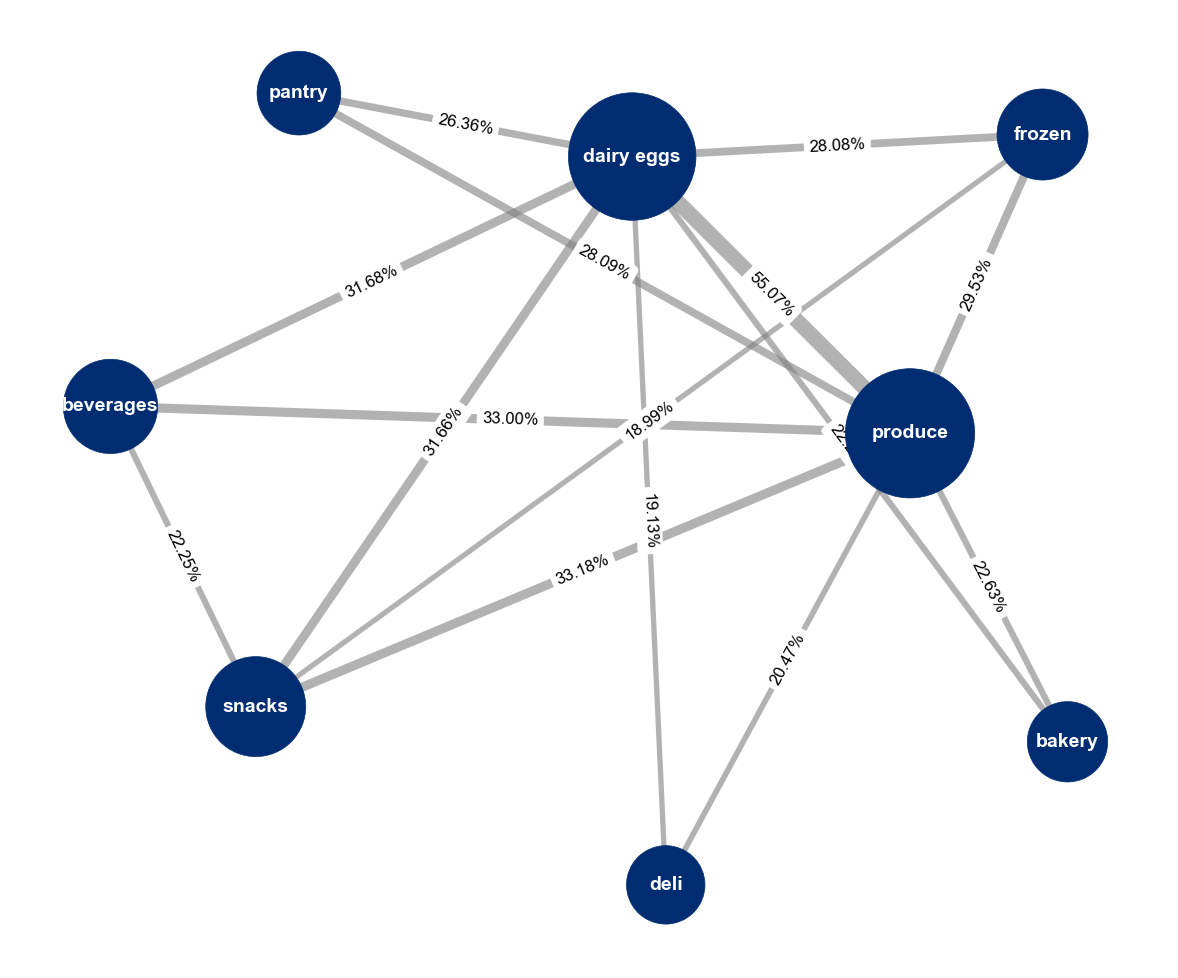

In [249]:
# Department network graph

df_dept = dept_itemsets_df.copy()

# Keep only top_n itemsets
top_n = 20
df_dept = df_dept.sort_values("support", ascending=False).head(top_n)

# Keep only itemsets of length 2
df_dept["Len"] = df_dept["itemset_names"].apply(lambda x: len(x))
df_pairs = df_dept[df_dept["Len"] == 2].copy()

# Build edges + node supports
edge_weights = {}
node_supports = {}

for _, row in df_pairs.iterrows():
    items = row["itemset_names"]
    
    a, b = sorted(items)
    supp = row["support"]

    # edge weight
    edge_weights[(a, b)] = supp

    # node support
    for item in (a, b):
        node_supports[item] = node_supports.get(item, 0) + supp

# Build graph
G = nx.Graph()

for item, s in node_supports.items():
    G.add_node(item, support=s)

for (a, b), w in edge_weights.items():
    G.add_edge(a, b, weight=w)

# Node sizes + edge widths
node_sizes = [2000 + node_supports[n] * 3000 for n in G.nodes()]
edge_widths = [G[u][v]["weight"] * 20 for u, v in G.edges()]

# Edge labels
edge_labels = {(u, v): f"{G[u][v]['weight']*100:.2f}%"
               for u, v in G.edges()}

# Wrap labels
wrapped_labels = {
    n: "\n".join(textwrap.wrap(n, width=12))
    for n in G.nodes()
}

# Plot
plt.figure(figsize=(12, 10), facecolor="white")

pos = nx.spring_layout(G, k=10, scale=10, iterations=300, seed=42)

# move "dairy eggs" a bit
if "dairy eggs" in pos:
    x, y = pos["dairy eggs"]
    pos["dairy eggs"] = (x - 0.2, y + 0.6) 


nx.draw_networkx_nodes(G, pos,
                       node_size=node_sizes,
                       node_color="#002D72",
                       alpha=1.0)

nx.draw_networkx_edges(G, pos,
                       width=edge_widths,
                       edge_color="gray",
                       alpha=0.6)

nx.draw_networkx_labels(G, pos,
                        labels=wrapped_labels,
                        font_size=14,
                        font_color="white",
                        font_weight="bold")

nx.draw_networkx_edge_labels(G, pos,
                             edge_labels=edge_labels,
                             font_size=12)

plt.axis("off")
plt.tight_layout()
plt.show()


In [124]:
df_dept

,itemset_ids,support_count,support,itemset_names,Len
38,"[4, 16]",274779,0.550723,"[produce, dairy eggs]",2
41,"[4, 19]",165551,0.331804,"[produce, snacks]",2
31,"[4, 7]",164638,0.329974,"[produce, beverages]",2
62,"[7, 16]",158041,0.316752,"[beverages, dairy eggs]",2
114,"[16, 19]",157951,0.316572,"[dairy eggs, snacks]",2
1,"[1, 4]",147348,0.295321,"[frozen, produce]",2
35,"[4, 13]",140161,0.280916,"[produce, pantry]",2
10,"[1, 16]",140127,0.280848,"[frozen, dairy eggs]",2
356,"[4, 16, 19]",132674,0.265911,"[produce, dairy eggs, snacks]",3
96,"[13, 16]",131518,0.263594,"[pantry, dairy eggs]",2


## 7. Sequential pattern mining

In [126]:
# segment 4 
segment_4_seq_df = segment_4_df[['user_id', 'order_id', 'aisle_id']].drop_duplicates()

In [127]:
# segment 4
segment_4_seq_df = segment_4_seq_df.sort_values(['user_id', 'order_id'])

segment_4_seq_df['rank'] = (
    segment_4_seq_df.groupby('user_id')['order_id']
    .rank(method='dense')
    .astype(int)
)


In [128]:
# 1) Order-level: for each (user, rank) get list of aisles in that order
order_level = (
    segment_4_seq_df
    .groupby(['user_id', 'rank'])['aisle_id']
    .apply(list)
)

# 2) User-level sequences: each user is a list of orders (each order is a list of aisles)
user_sequences = (
    order_level
    .groupby(level=0)   # group by user_id (index level 0)
    .apply(list)
    .tolist()           # final list of sequences for PrefixSpan
)

print(f"Number of users (sequences): {len(user_sequences)}")
print("Example sequence for one user:\n", user_sequences[0])


Number of users (sequences): 6748
Example sequence for one user:
 [[84, 112, 92, 98, 107, 23], [84, 112, 120, 86, 83, 24], [104, 112, 84]]


In [129]:
# sequences
user_sequences = [
    [tuple(order) for order in sequence]
    for sequence in user_sequences
]


In [130]:
# Convert each order's aisle list into a tuple (hashable)
user_sequences = [
    [tuple(order) for order in user_orders]
    for user_orders in user_sequences
]


In [131]:
# Initialize PrefixSpan
ps = PrefixSpan(user_sequences)

# Pattern length constraints
ps.minlen = 2       # allow single-step patterns
ps.maxlen = 4       

# Support threshold tuning
total_users = len(user_sequences)

# Try 0.1% support
minsup_fraction = 0.001
minsup = max(2, int(total_users * minsup_fraction))
print("Using minsup:", minsup)

# Mine patterns
patterns = ps.frequent(minsup)

# Sort by support
patterns = sorted(patterns, key=lambda x: x[0], reverse=True)

# Show results
for sup, seq in patterns[:15]:
    print(f"support={sup}/{total_users} ({sup/total_users:.3%})  sequence={seq}")


Using minsup: 6
support=13/6748 (0.193%)  sequence=[(24,), (24,)]
support=11/6748 (0.163%)  sequence=[(92,), (92,)]
support=7/6748 (0.104%)  sequence=[(84,), (84,)]


In [132]:
# Map aisle_id to aisle_name
aisle_map = dict(zip(aisles['aisle_id'], aisles['aisle']))

total_users = len(user_sequences)

def seq_to_text(seq):
    """
    seq is something like: [(84,), (83,), (120, 123)]
    Return: 'fresh fruits → fresh vegetables → packaged vegetables + yogurt'
    """
    steps = []
    for order in seq:
        # order is a tuple of aisle_ids
        labels = [aisle_map.get(i, str(i)) for i in order]
        steps.append(" + ".join(labels))   # aisles in the same order
    return " → ".join(steps)               # sequence across orders

rows = []
for sup, seq in patterns[:50]:   # take top 50
    rows.append({
        "support_abs": sup,
        "support_pct": sup / total_users,
        "length": len(seq),
        "sequence_text": seq_to_text(seq)
    })

patterns_df = pd.DataFrame(rows).sort_values("support_pct", ascending=False)

patterns_df.head(10)


,support_abs,support_pct,length,sequence_text
0,13,0.001926,2,fresh fruits → fresh fruits
1,11,0.001630,2,baby food formula → baby food formula
2,7,0.001037,2,milk → milk


In [133]:
# Recommendation function
 
def get_next_order_recommendations(last_purchased_aisle, patterns_df, top_n=3):
    """
    Recommends aisles for the next order based on sequential patterns.
 
    :param last_purchased_aisle: The aisle_id the user bought in their last order.
    :param patterns_df: The DataFrame of sequential patterns (aisle_A -> aisle_B).
    :param top_n: The number of top recommendations to return.
    :return: A list of recommended aisles (aisle_id).
    """
    # Filter for patterns where aisle_A matches the last purchased aisle
    recommendations = patterns_df[patterns_df['aisle_A'] == last_purchased_aisle].copy()
 
    if recommendations.empty:
        return []
 
    # Calculate 'Confidence' (simplified as P(B|A) = count(A->B) / count(A))
    # This represents the probability that B will be bought next, given A was bought now.
    count_A = patterns_df[patterns_df['aisle_A'] == last_purchased_aisle]['support_count'].sum()
    recommendations['confidence'] = recommendations['support_count'] / count_A
 
    # Sort by confidence and get the top N
    recommendations = recommendations.sort_values(by='confidence', ascending=False)
 
    return recommendations['aisle_B'].head(top_n).tolist()

 
# 2. Data Preparation: Structure data into sequences of itemsets (orders)
# Ensure data is sorted chronologically
df_orders = segment_4_seq_df.sort_values(['user_id', 'order_id'])
 
# Group all AISLE_IDs purchased in the same order into a list (the 'itemset')
df_sequences = df_orders.groupby(['user_id', 'order_id'])['aisle_id'].apply(list).reset_index(name='itemset')
 
# 3. Create transitions from Itemset N to Itemset N+1
# The .shift(-1) operation brings the next order's itemset into the current row
df_sequences['next_order_id'] = df_sequences.groupby('user_id')['order_id'].shift(-1)
df_sequences['next_itemset'] = df_sequences.groupby('user_id')['itemset'].shift(-1)
 
# Drop the last order for each user as it has no 'next_itemset'
df_transitions = df_sequences.dropna(subset=['next_itemset']).copy()
 
# 4. get all sequential item pairs (Aisle A in Order N -> Aisle B in Order N+1)
# creates a row for every combination of (Aisle A in current order, Aisle B in next order)
df_transitions_A = df_transitions.explode('itemset').rename(columns={'itemset': 'aisle_A'})
df_transitions_final = df_transitions_A.explode('next_itemset').rename(columns={'next_itemset': 'aisle_B'})

df_transitions_final = df_transitions_final[df_transitions_final['aisle_A'] != df_transitions_final['aisle_B']]
 
# 5. Sequential Pattern Mining (Count frequency/support)
# core of recommendation system
sequential_patterns = df_transitions_final.groupby(['aisle_A', 'aisle_B']).size().reset_index(name='support_count')
sequential_patterns = sequential_patterns.sort_values(by='support_count', ascending=False).reset_index(drop=True)
 
# Recommendation example
user_last_item = 40 
recommendations = get_next_order_recommendations(user_last_item, sequential_patterns)
 
print("\n--- Sequential Pattern Mining Results (Top 10) ---")
print(sequential_patterns.head(20))
 
print(f"\nIf a customer bought items from 'aisle_id' **{user_last_item}** in their last order,")
print(f"the top recommendations (next aisles) for their next order are: **{recommendations}**")


--- Sequential Pattern Mining Results (Top 10) ---
    aisle_A  aisle_B  support_count
0        83       24          13231
1        24       83          13122
2        24      123          11391
3       123       24          11377
4       120       24           9852
5        24      120           9821
6        84       24           9276
7        24       84           9230
8        83      123           8904
9       123       83           8863
10       24       92           8288
11       92       24           8269
12       21       24           8187
13       24       21           8130
14      120       83           7468
15       83      120           7467
16       83       84           7036
17       84       83           7028
18      120      123           6622
19      123      120           6572

If a customer bought items from 'aisle_id' **40** in their last order,
the top recommendations (next aisles) for their next order are: **[24, 83, 123]**


In [134]:
sequential_patterns.head(20)

,aisle_A,aisle_B,support_count
0,83,24,13231
1,24,83,13122
2,24,123,11391
3,123,24,11377
4,120,24,9852
5,24,120,9821
6,84,24,9276
7,24,84,9230
8,83,123,8904
9,123,83,8863


In [135]:
# Recommendation example
user_last_item = 123 
recommendations = get_next_order_recommendations(user_last_item, sequential_patterns)
 
print("\n" + "="*70)
print(" Sequential Pattern Mining Analysis (Aisle Transitions)")
print("="*70)
 
# 1. Display the Core Sequential Patterns Table (Top 10)
print("\n Top 10 Sequential Aisle Patterns (Support Count)")
print("This shows the most frequent transitions from one aisle (A) to another (B) in subsequent orders.")
 
# Rename columns for display clarity
display_patterns = sequential_patterns.head(5).copy()
display_patterns.columns = ['Aisle_A (Previous Order)', 'Aisle_B (Next Order)', 'Transition Count (Support)']
 
print(display_patterns.to_markdown(index=False))
 
# 2. Display the Specific Recommendations and Confidence
print("\n" + "-"*70)
print(f" Next-Order Recommendations for Aisle ID: {user_last_item}")
print("-" * 70)
 
if recommendations:
    # Recalculate recommendations dataframe to show confidence for display
    rec_df = sequential_patterns[sequential_patterns['aisle_A'] == user_last_item].copy()
    # Calculate Confidence
    count_A = sequential_patterns[sequential_patterns['aisle_A'] == user_last_item]['support_count'].sum()
    rec_df['confidence'] = rec_df['support_count'] / count_A
    # Sort and format for output
    rec_df = rec_df.sort_values(by='confidence', ascending=False)
    rec_df = rec_df.rename(columns={'aisle_A': 'Current Aisle (A)', 'aisle_B': 'Recommended Next Aisle (B)', 'support_count': 'Count (A->B)'})
    # Select top N and format confidence as percentage
    top_n_rec = rec_df.head(3)
    top_n_rec['confidence'] = (top_n_rec['confidence'] * 100).map('{:.2f}%'.format)
 
    print(f"If a user bought items from Aisle ID {user_last_item} in their last order...")
    print(top_n_rec[['Recommended Next Aisle (B)', 'confidence', 'Count (A->B)', 'Current Aisle (A)']].to_markdown(index=False))
    print("\n Conclusion: The model suggests the user is most likely to visit these aisles next.")
else:
    print(f"No sequential patterns found starting from Aisle ID {user_last_item}.")


 Sequential Pattern Mining Analysis (Aisle Transitions)

 Top 10 Sequential Aisle Patterns (Support Count)
This shows the most frequent transitions from one aisle (A) to another (B) in subsequent orders.
|   Aisle_A (Previous Order) |   Aisle_B (Next Order) |   Transition Count (Support) |
|---------------------------:|-----------------------:|-----------------------------:|
|                         83 |                     24 |                        13231 |
|                         24 |                     83 |                        13122 |
|                         24 |                    123 |                        11391 |
|                        123 |                     24 |                        11377 |
|                        120 |                     24 |                         9852 |

----------------------------------------------------------------------
 Next-Order Recommendations for Aisle ID: 123
--------------------------------------------------------------------

In [136]:
# Merge aisle_A to get aisle_A name
patterns_final = sequential_patterns.merge(
    aisles.rename(columns={'aisle_id': 'aisle_A', 'aisle': 'aisle_A_name'}),
    on='aisle_A',
    how='left'
)

# Merge aisle_B to get aisle_B name
patterns_final = patterns_final.merge(
    aisles.rename(columns={'aisle_id': 'aisle_B', 'aisle': 'aisle_B_name'}),
    on='aisle_B',
    how='left'
)


In [137]:
patterns_final.describe()

,aisle_A,aisle_B,support_count
count,16599.000000,16599.000000,16599.000000
mean,67.173022,67.196879,183.443099
std,38.426699,38.377469,528.883890
min,1.000000,1.000000,1.000000
25%,34.000000,34.000000,8.000000
50%,67.000000,67.000000,33.000000
75%,100.000000,100.000000,144.000000
max,134.000000,134.000000,13231.000000
